In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier



from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor


from textwrap import wrap
from functools import reduce

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import remove_outliers, get_continuous_attributes_except, get_categorical_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model
from main.components.feature_importance_methods import get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf, rename_importnace_col, merge_feature_importances, rank_importances, feature_selection_mutual_info_regression, recursive_feature_elimination, get_permutation_importance

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
raw_df = pd.read_csv(dataset_file_path)
raw_df.sample(5)

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro  IGF-1 ng/ml (N: 100-311)  proBNP  AMH (ng/ml) *7,14=pmol/l  weight  height (cm)        BMI  systolic BP (ciśnienie skurczowe)  diastolic BP (ciśnienie rozskurczowe)  Hypertension  Waist Circumference (WC)  WC>88  Hip Circumference (HC)  WHR (Waist/Hip ratio)  WHR>0,85 (WHO)  WHR>0,8 (NIDDK)  WHTR (Waist/Height Ratio)  WHTR>0,5  overweight/obesity 0-normal/low, 1-overweight, 2-obesity  irregular cycles (0-nie, 1-tak)  ovulation (0-brak, 1-obecna)  PCO ovary morfology in USG (0-brak, 1--obecna)  stromal hypertrophy in ovary (0-brak, 1-obecny)  acne  hirsutism  FG score (Ferriman-Gallway score - stopień androgenizacji)  hyperandrogenism  hypothyroidism  Volume of the thyroid  Right Lobe  Volume of the thyroid  Left Lobe  thyroid volume  nodules 0-lack, 1-RL,  2-LL, 3-both  chronic thyroiditis  Vole of the Right Ovary  Volume of the  Left Ovary  ovaries volume - total  follicules >12  WBC x10^3/ul  neutrophil x10^3/ul  \
836                                                         2                     162.0   13.00                  2.225490    77.0        167.5  27.444865                              125.0                                   55.0           0.0                      77.0    0.0                    87.0               0.885057             1.0              1.0                   0.459701       0.0                                                       1.0                              1.0                           0.0                                             0.0                                              0.0   0.0        1.0                                                        14.0               1.0             0.0                           4.582500                           3.80250        8.385000                                  0.0                  0.0                     8.50                       8.10                   16.60             0.0          6.48                 3.48   
798                                                         2                     210.0     NaN                       NaN    50.0        151.0  21.928863                                NaN                                    NaN           NaN                       NaN    NaN                     NaN                    NaN             NaN              NaN                        NaN       NaN                                                       0.0                              1.0                           NaN                                             1.0                                              NaN   NaN        NaN                                                         NaN               NaN             NaN                           9.915300                           4.47865       14.393950                                  NaN                  NaN                     8.13                       5.13                   13.26             1.0          4.86                  NaN   
945                                                         4                       NaN     NaN                       NaN    69.0        163.0  25.970116                               98.0                                   74.0           0.0                      84.0    0.0                    90.0               0.933333             1.0              1.0                   0.515337       1.0                                                       1.0                              1.0                           0.0                                             0.0                                              1.0   0.0        1.0                                                         NaN               1.0             0.0                           4.506432                           3.31947        7.825902                                  NaN                  NaN                     6.53                       4.18                   10.71             0.0          5.81                 3.42   
406                          

### Handle `vitamine D ` outliers

Left only the values within the interval: [-13.35, 64.45]
Removed 6 outlier values of vitamin 25-OH D ng/ml -> 1.07 % of all the not null examples


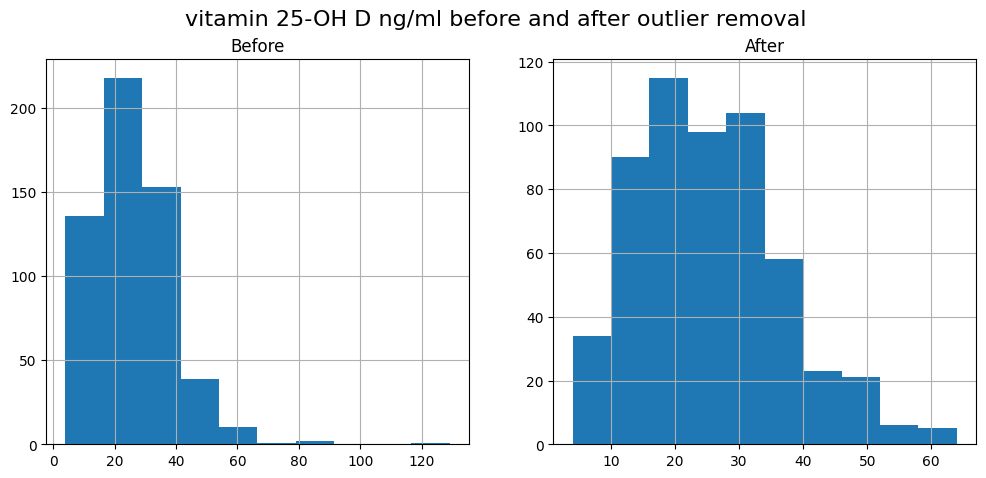

In [3]:
df = remove_outliers(raw_df, VITAMINE_D)

# Model selection for vitamin D

In [4]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_test_vit_d, y_train_vit_d, y_test_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

Best preprocessing techniques for vitamine D:
- PT_KNN  + original_ohe_no_imputing

In [5]:
tree_continuous_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()),
                                    ('imputer', KNNImputer(n_neighbors=9))
                                    ])
linear_continuous_preprocessor =  Pipeline([('scaler', PowerTransformer()),
                                            ('imputer', KNNImputer(n_neighbors=9)),
                                            ('poly',  PolynomialFeatures(degree=2, interaction_only=True))
                                            ])

categorical_preprocessor = Pipeline([
    ('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))
    ])

### Hyperparameter tuning

### Lasso

Lasso with polynomial features

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__alpha': 1}
Best score (neg_mean_absolute_error): -8.710032970277023


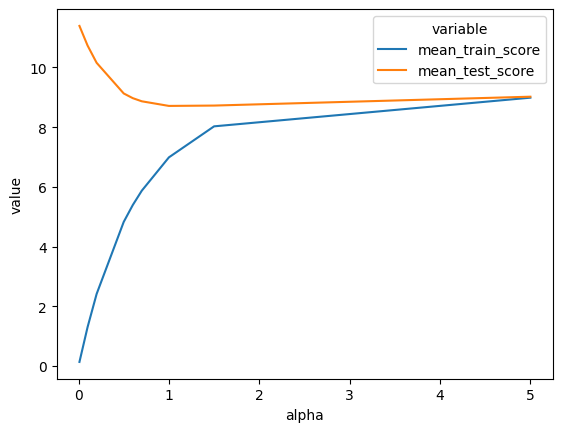

alpha  mean_train_score  mean_test_score
0  0.01          0.140187        11.387913
1   0.1          1.305675        10.730554
2   0.2          2.414885        10.153626
3   0.5          4.827742         9.127120
4   0.6          5.390699         8.970097
5   0.7          5.872792         8.864744
6     1          6.987976         8.710033
7   1.5          8.026328         8.721792
8     5          8.985761         9.018594

In [28]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
}

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), linear_continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

C=0.5

Lasso with regular features

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__alpha': 0.6}
Best score (neg_mean_absolute_error): -8.53146054969854


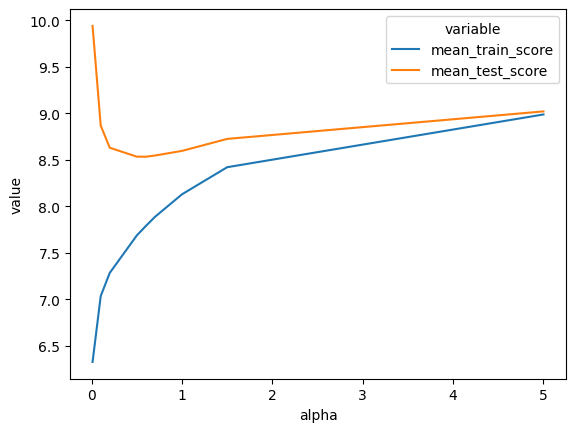

alpha  mean_train_score  mean_test_score
0  0.01          6.325230         9.937780
1   0.1          7.032682         8.866931
2   0.2          7.282339         8.627873
3   0.5          7.685633         8.532239
4   0.6          7.787173         8.531461
5   0.7          7.884552         8.544234
6     1          8.127694         8.594232
7   1.5          8.418870         8.723130
8     5          8.985761         9.018594

In [29]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

Selected alpha: 0.2

### Ridge

Rigde + polynomial features

Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best parameters: {'model__alpha': 1000}
Best score (neg_mean_absolute_error): -9.510787208833584


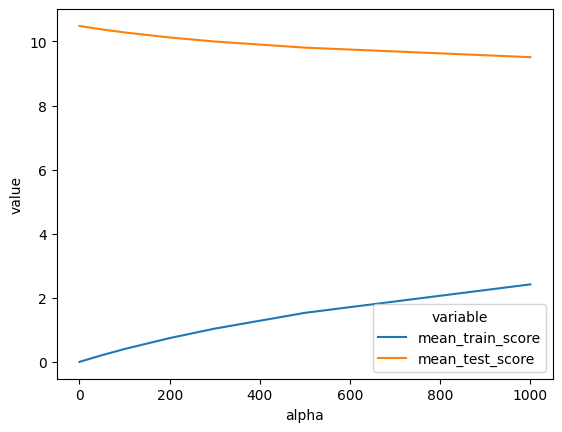

alpha  mean_train_score  mean_test_score
0   0.000001      4.417973e-09        10.485612
1       0.01      4.417929e-05        10.485588
2        0.1      4.417533e-04        10.485370
3          1      4.413583e-03        10.483195
4         10      4.374578e-02        10.462049
5         50      2.105833e-01        10.376311
6        100      4.029228e-01        10.282001
7        200      7.437959e-01        10.124766
8        300      1.039001e+00         9.998972
9        500      1.531725e+00         9.807763
10      1000      2.420003e+00         9.510787
11      1000      2.420003e+00         9.510787

In [36]:
ridge_param_grid = {
    "model__alpha": [0.000001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 500, 1000, 1000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), linear_continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Rigde

Fitting 15 folds for each of 6 candidates, totalling 90 fits
Best parameters: {'model__alpha': 500}
Best score (neg_mean_absolute_error): -8.49180752043109


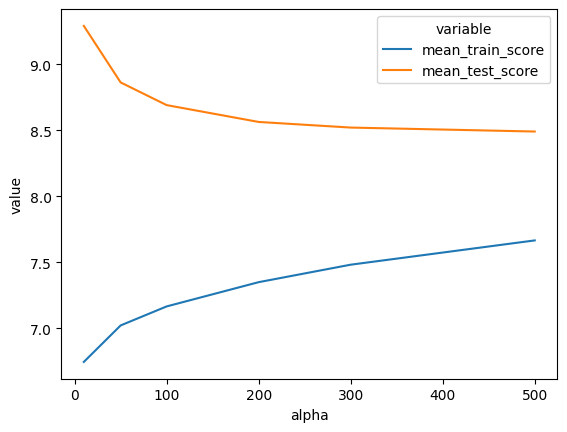

alpha  mean_train_score  mean_test_score
0    10          6.745464         9.292248
1    50          7.022055         8.863978
2   100          7.166139         8.692041
3   200          7.350007         8.564375
4   300          7.482459         8.521817
5   500          7.666460         8.491808

In [37]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Best alpha: 100 lub 200

### DecisionTreeRegressor

In [43]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [8, 9, 10, 12],
    # "model__splitter": ["random", "best"],
    "model__min_samples_split": [15, 16, 17, 20],
    "model__min_samples_leaf": [20, 22, 25, 27],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, tree_model, continuous_preprocessor, categorical_preprocessor, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 64 candidates, totalling 960 fits
Best parameters: {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}
Best score (neg_mean_absolute_error): -9.544982124616956


params  mean_train_score  mean_test_score
62  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}          7.197525         9.544982
61  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}          7.197525         9.547255
45  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}          7.197525         9.549149
60  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}          7.197525         9.549511
29   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}          7.197525         9.551783
47  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}          7.200529         9.554503
28   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}          7.186225         9.557763
14   {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}          7.197525         9.560891
44  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}          7.197525         9.564611
63  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}          7.186225         9.565288
30   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}          7.200529         9.566884
15   {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}          7.189230         9.567233
13   {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16}          7.200529         9.568020
12   {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 15}          7.186225         9.571399
31   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20}          7.186225         9.575498
46  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17}          7.189230         9.587240
57  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16}          7.122642         9.640437
9    {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16}          7.120013         9.647255
8    {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15}          7.120013         9.654073
6    {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 22, 'model__min_samples_split': 17}          6.955987         9.654469
58  {'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 17}          7.116633         9.655209
7    {'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 22, 'model__min_samples_split': 20}          6.962576         9.655805
26   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 25, 'model__min_samples_split': 17}          7.112094         9.658678
20   {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 22, 'model__min_samples_split': 15}          6.953933         9.65979

In [11]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


cv_mae
62  -9.07908
58 -9.187412
14 -9.191769
51 -9.192326
83 -9.193849

### Random Forest

In [42]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 5, 7],
    'model__min_samples_leaf': [3, 5, 7],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, RandomForestRegressor(criterion="absolute_error"), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


params  mean_train_mae  mean_test_mae
8   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}        6.047948       8.726923
15  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}        6.544893       8.740124
1   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}        5.119564       8.741829
17  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 200}        6.547260       8.743113
16  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 100}        6.558310       8.747370
7   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}        6.049708       8.749739
14  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 100}        6.570497       8.753219
13  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}        6.547810       8.758884
9   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}        6.038521       8.759326
10  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 100}        6.066576       8.763497
2   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 5, 'model__n_estimators': 100}        5.128704       8.763918
11  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 200}        6.038105       8.764692
6   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 100}        6.066545       8.766268
5   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 200}        5.215093       8.766899
4   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 100}        5.210646       8.773785
3   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 5, 'model__n_estimators': 200}        5.111102       8.775665
12  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 100}        6.557395       8.780446
0   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 100}        5.130075       8.801920

In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, criterion='absolute_error')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:45<00:00,  5.92s/it]


cv_mae
13 -8.697161
16 -8.713622
7  -8.714204
61 -8.714876
72 -8.717986

#### SVR

In [39]:
param_grid_svr = {
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [0.1, 1, 10],
    'model__degree': [2],
    'model__epsilon': [0.1, 0.2, 0.3],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, SVR(), continuous_preprocessor, categorical_preprocessor, param_grid_svr)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 108 candidates, totalling 1620 fits


Best parameters: {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'linear'}
Best score (neg_mean_absolute_error): -8.871501308562694


params  mean_train_score  mean_test_score
18   {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'linear'}          6.751976         8.871501
21     {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 1, 'model__kernel': 'linear'}          6.751976         8.871501
24    {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 10, 'model__kernel': 'linear'}          6.751976         8.871501
12     {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 1, 'model__kernel': 'linear'}          6.742408         8.876607
9    {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 0.1, 'model__kernel': 'linear'}          6.742408         8.876607
15    {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 10, 'model__kernel': 'linear'}          6.742408         8.876607
0    {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'linear'}          6.732536         8.884952
3      {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 1, 'model__kernel': 'linear'}          6.732536         8.884952
6     {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'linear'}          6.732536         8.884952
73       {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          2.352393         8.993749
79        {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 10, 'model__kernel': 'rbf'}          2.352481         8.993824
76         {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 1, 'model__kernel': 'rbf'}          2.352481         8.993824
64       {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          2.290734         8.993984
70        {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 10, 'model__kernel': 'rbf'}          2.290825         8.994061
67         {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.2, 'model__gamma': 1, 'model__kernel': 'rbf'}          2.290825         8.994061
55       {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          2.228835         8.994208
58         {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 1, 'model__kernel': 'rbf'}          2.228893         8.994287
61        {'model__C': 10, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'rbf'}          2.228893         8.994287
1       {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          8.854951         9.011478
4         {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 1, 'model__kernel': 'rbf'}          8.854957         9.011482
7        {'model__C': 0.1, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'rbf'}          8.854957         9.011482
46        {'model__C': 1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          8.004299         9.017818
52         {'model__C': 1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 10, 'model__kernel': 'rbf'}          8.004341         9.017851
49          {'model__C': 1, 'model__degree': 2, 'model__epsilon': 0.3, 'model__gamma': 1, 'model__kernel': 'rbf'}          8.004341         9.017851
88       {'model__C': 100, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 10, 'model__kernel': 'rbf'}          0.099489         9.018815
85        {'model__C': 100, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma': 1, 'model__kernel': 'rbf'}          0.099489         9.018815
82      {'model__C': 100, 'model__degree': 2, 'model__epsilon': 0.1, 'model__gamma':

## Best models for Vitamine D

#### Linear Regression

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


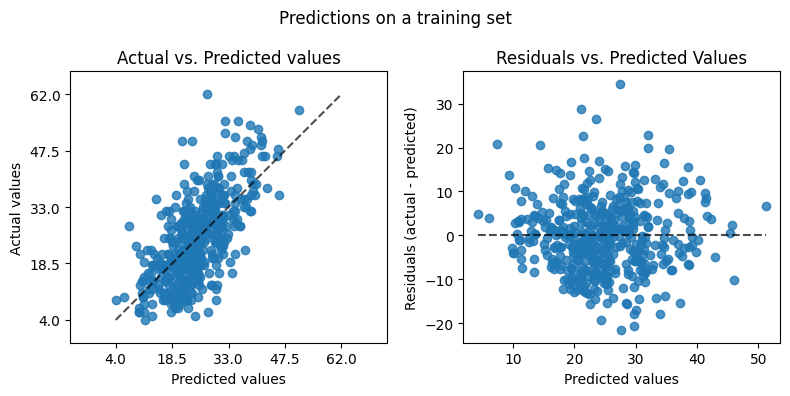

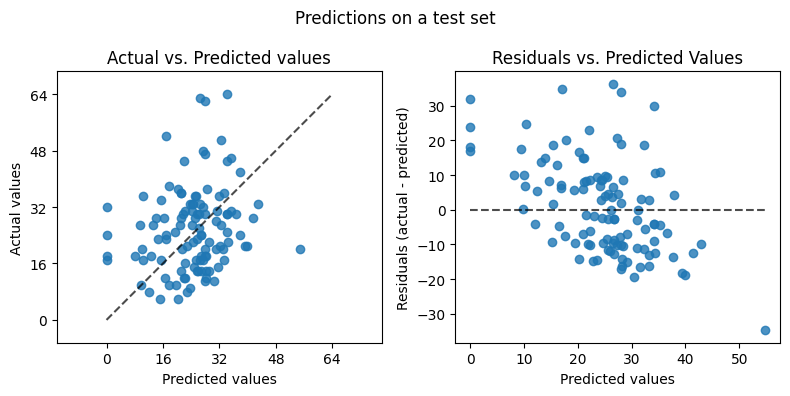

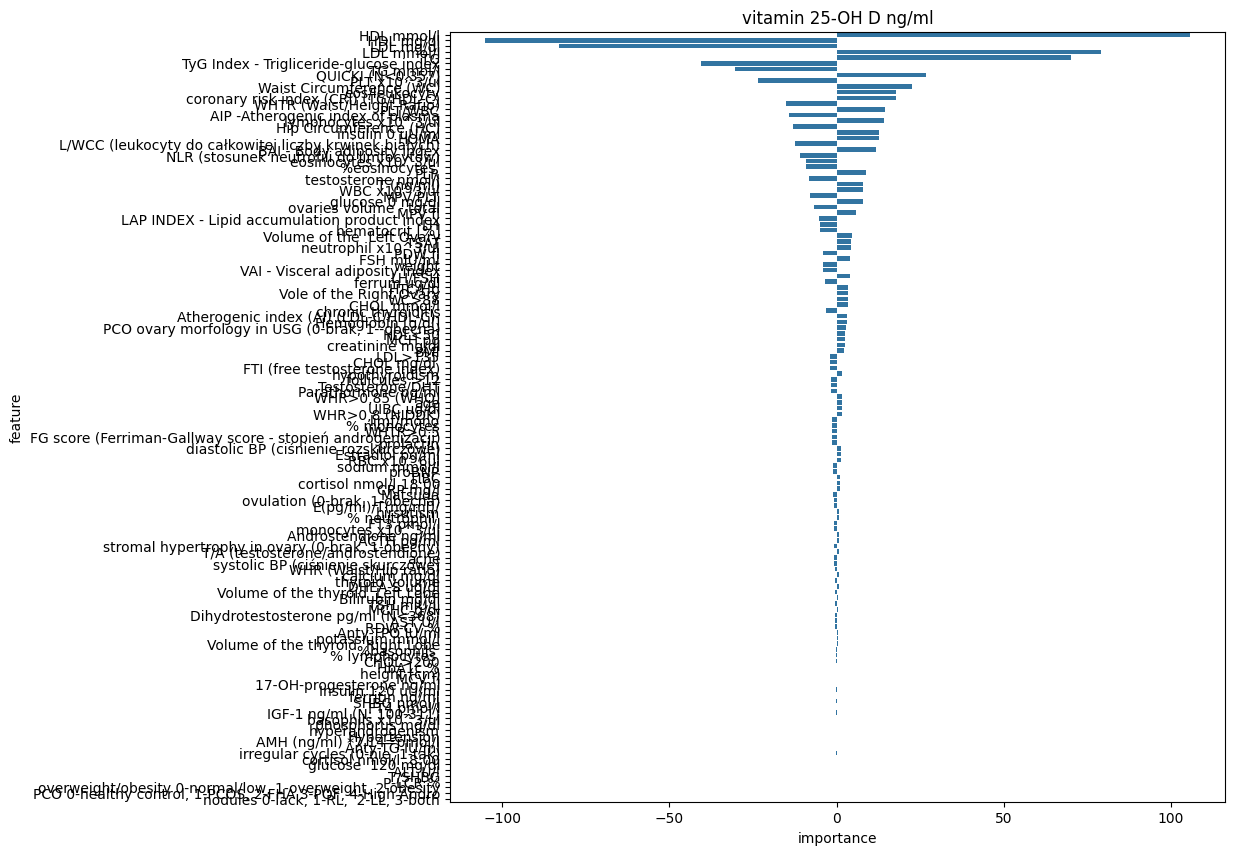

model  data_set      mse     mae    rmse     r2
0  LinearRegression()  training   68.345   6.502   8.267  0.445
1  LinearRegression()      test  185.359  11.195  13.615 -0.313

In [6]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

#### Linear Regression with Polynomial Features

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


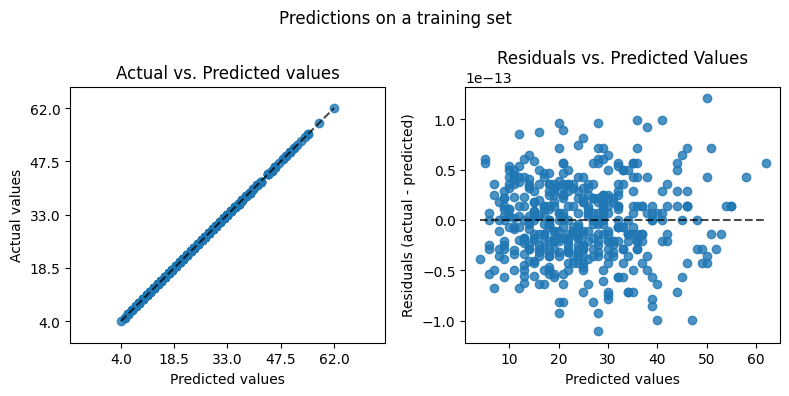

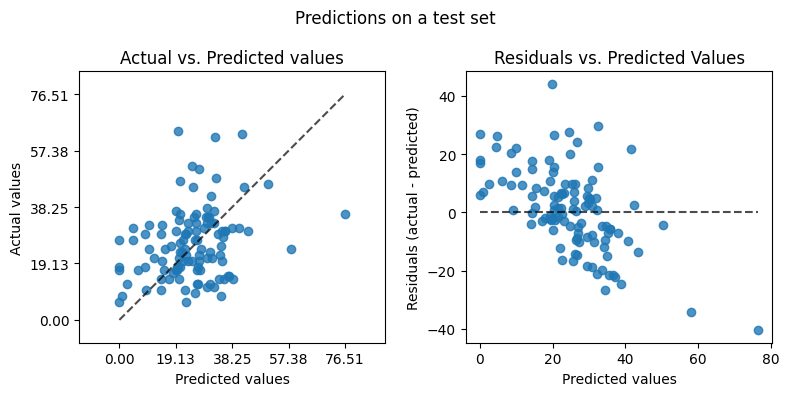

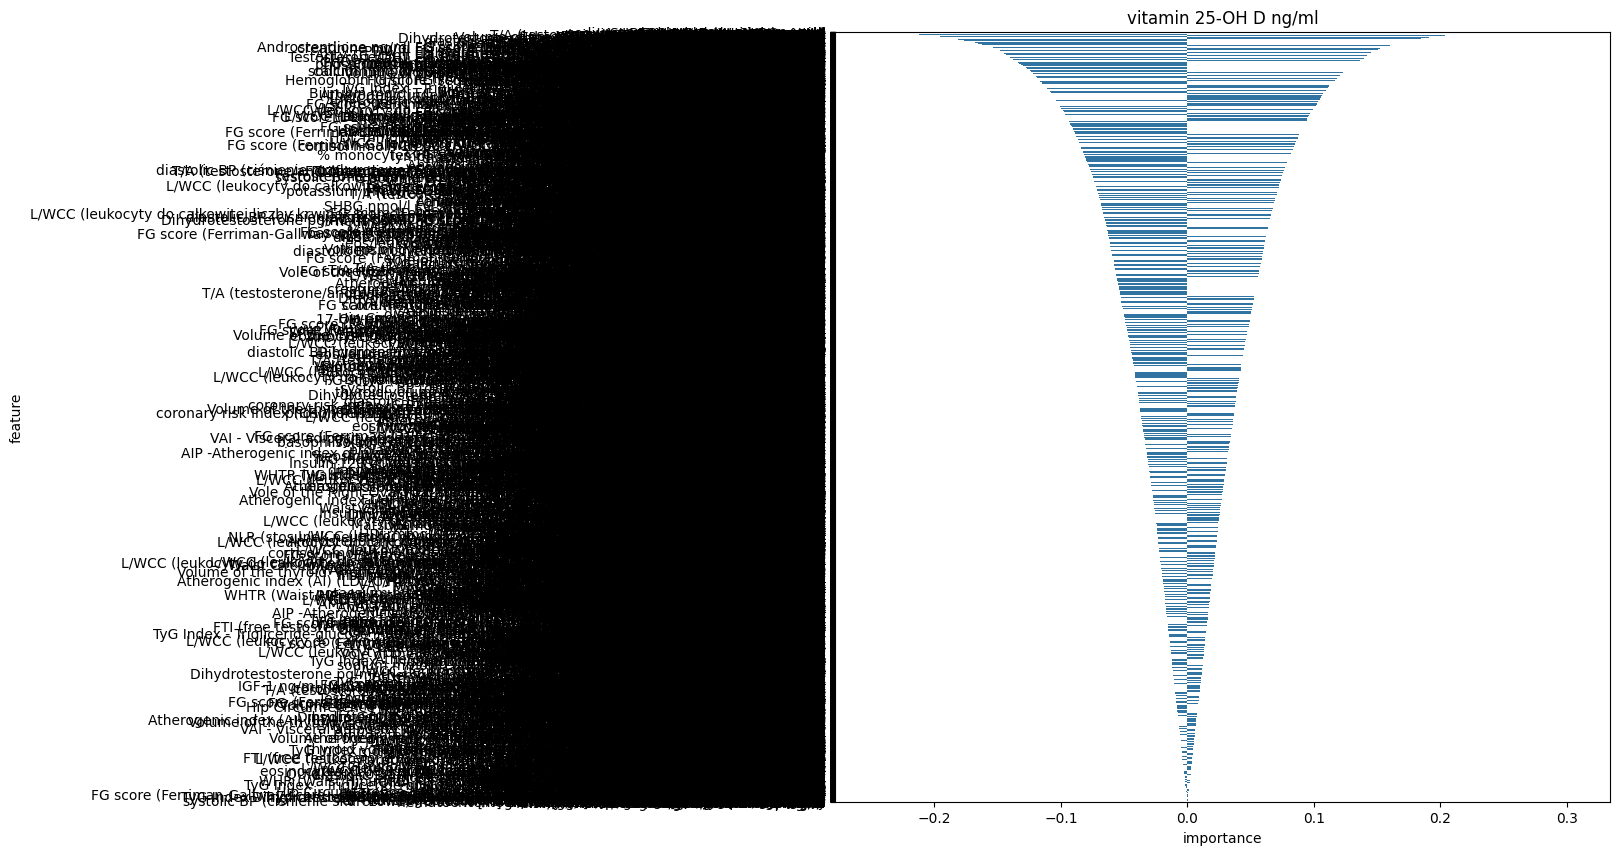

model  data_set      mse    mae  rmse     r2
0  LinearRegression()  training    0.000   0.00   0.0  1.000
1  LinearRegression()      test  201.648  11.01  14.2 -0.428

In [7]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr_poly = train_model(lr_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Lasso + polynomial features

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


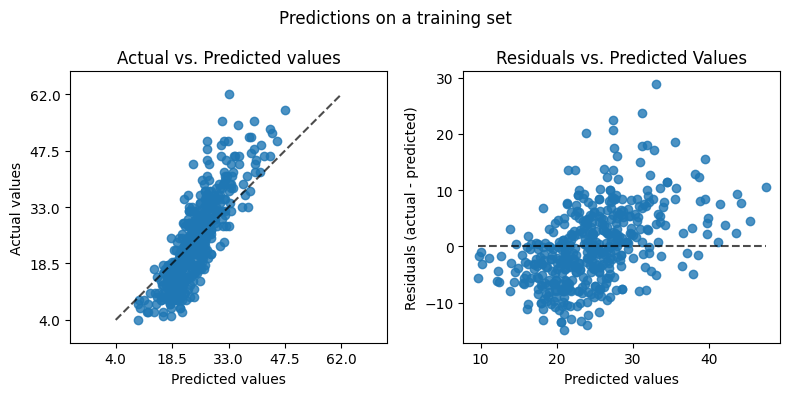

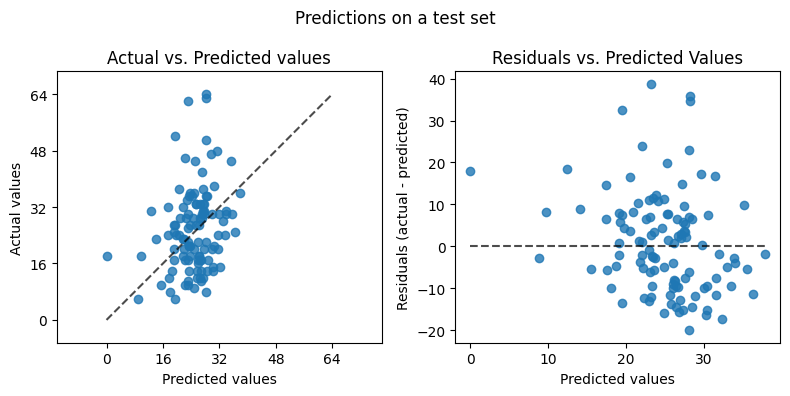

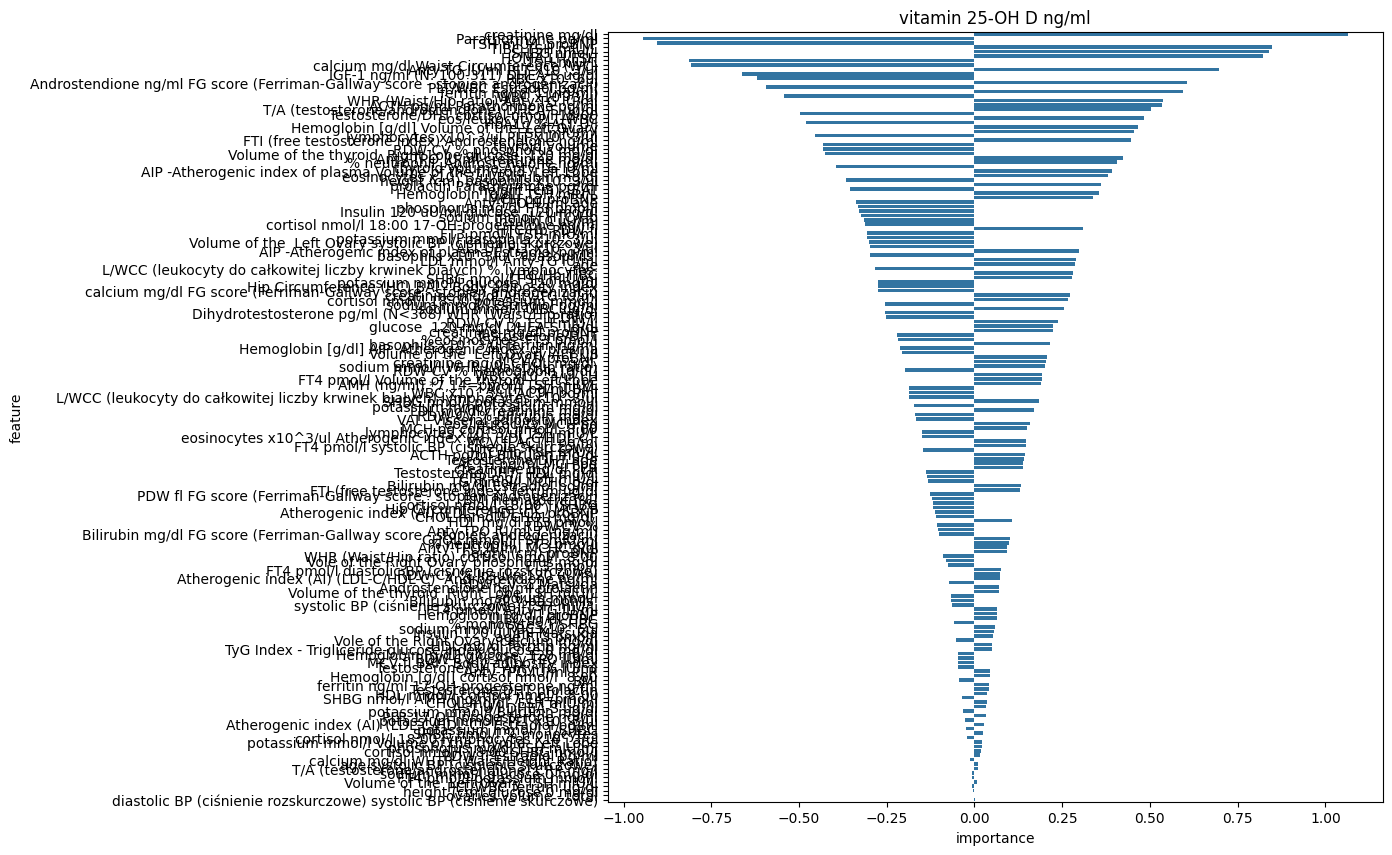

model  data_set      mse    mae    rmse     r2
0  Lasso(alpha=0.5)  training   46.644  5.379   6.830  0.621
1  Lasso(alpha=0.5)      test  142.305  9.434  11.929 -0.008

In [8]:
poly_lasso_model = Lasso(alpha=0.5)

vit_d_model_scores_df, feature_importnces_lasso_poly = train_model(poly_lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Lasso without polynomial features

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


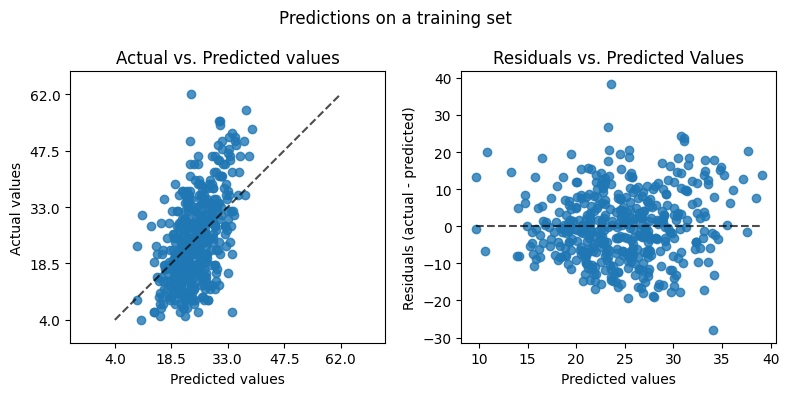

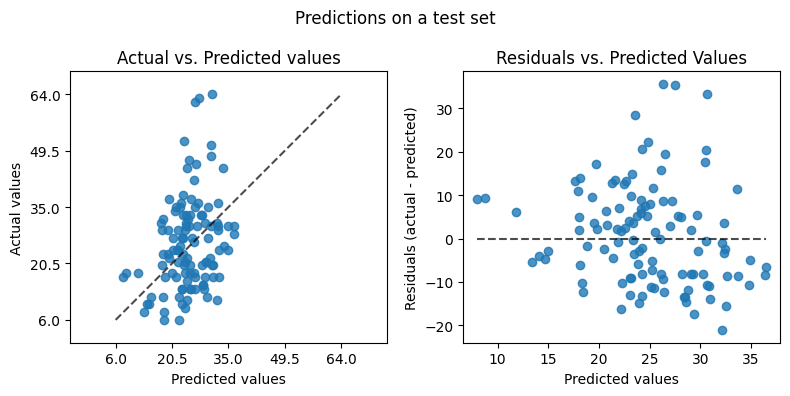

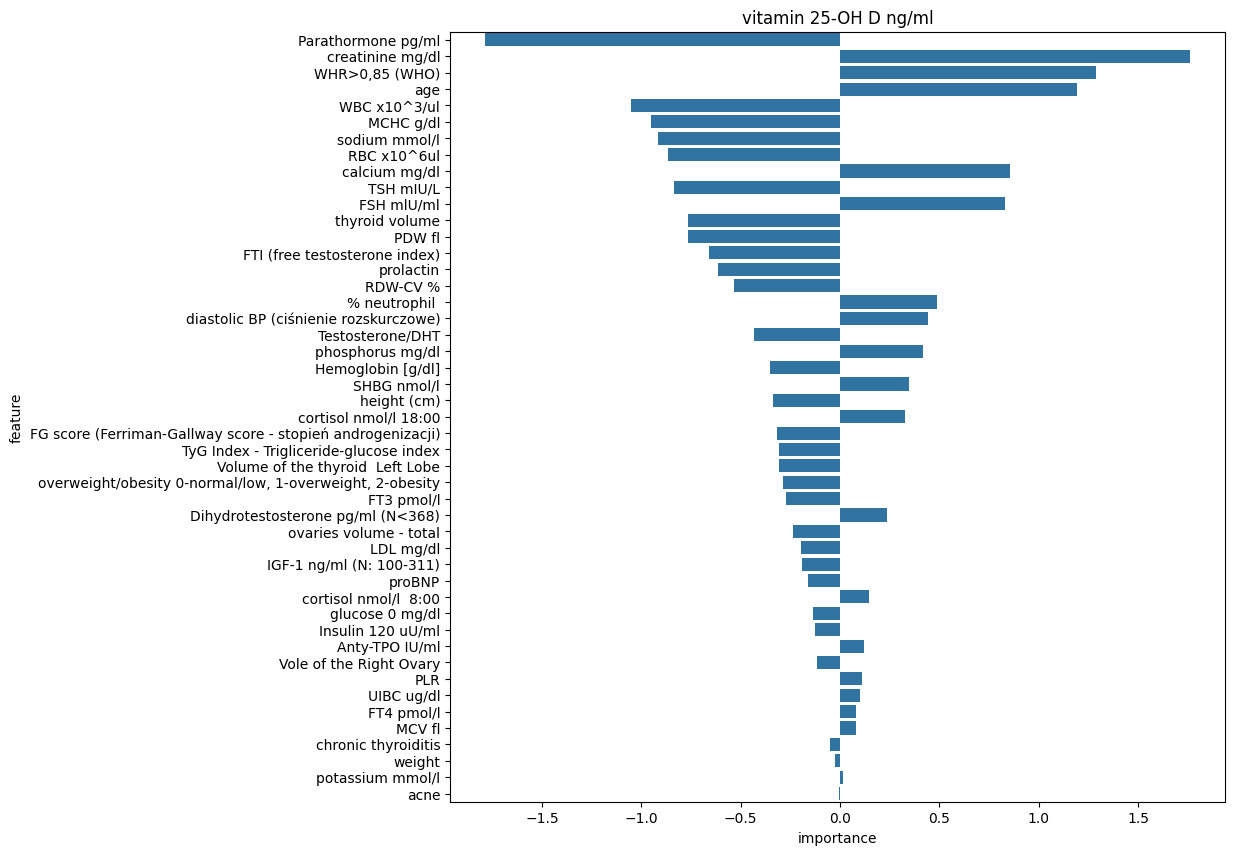

model  data_set      mse    mae    rmse     r2
0  Lasso(alpha=0.2)  training   87.829  7.492   9.372  0.287
1  Lasso(alpha=0.2)      test  134.829  9.330  11.612  0.045

In [9]:
lasso_model = Lasso(alpha=0.2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

#### Ridge

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


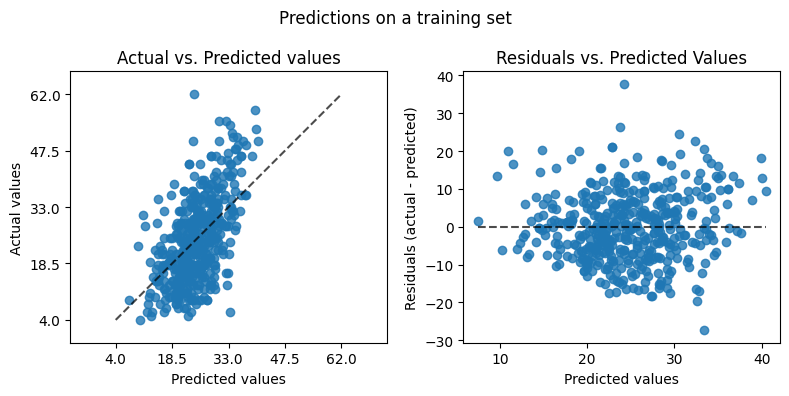

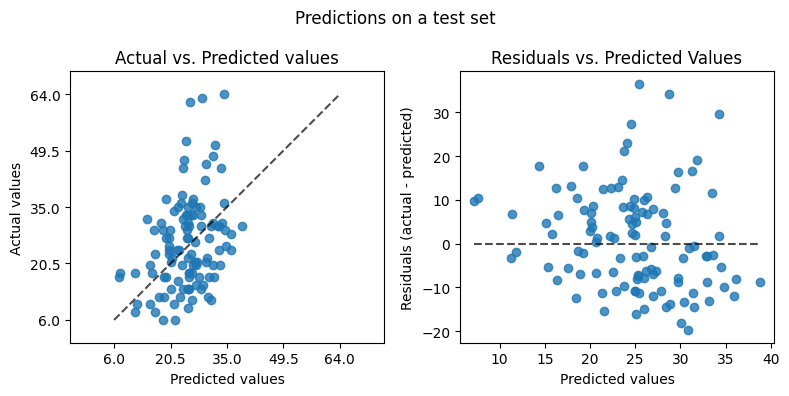

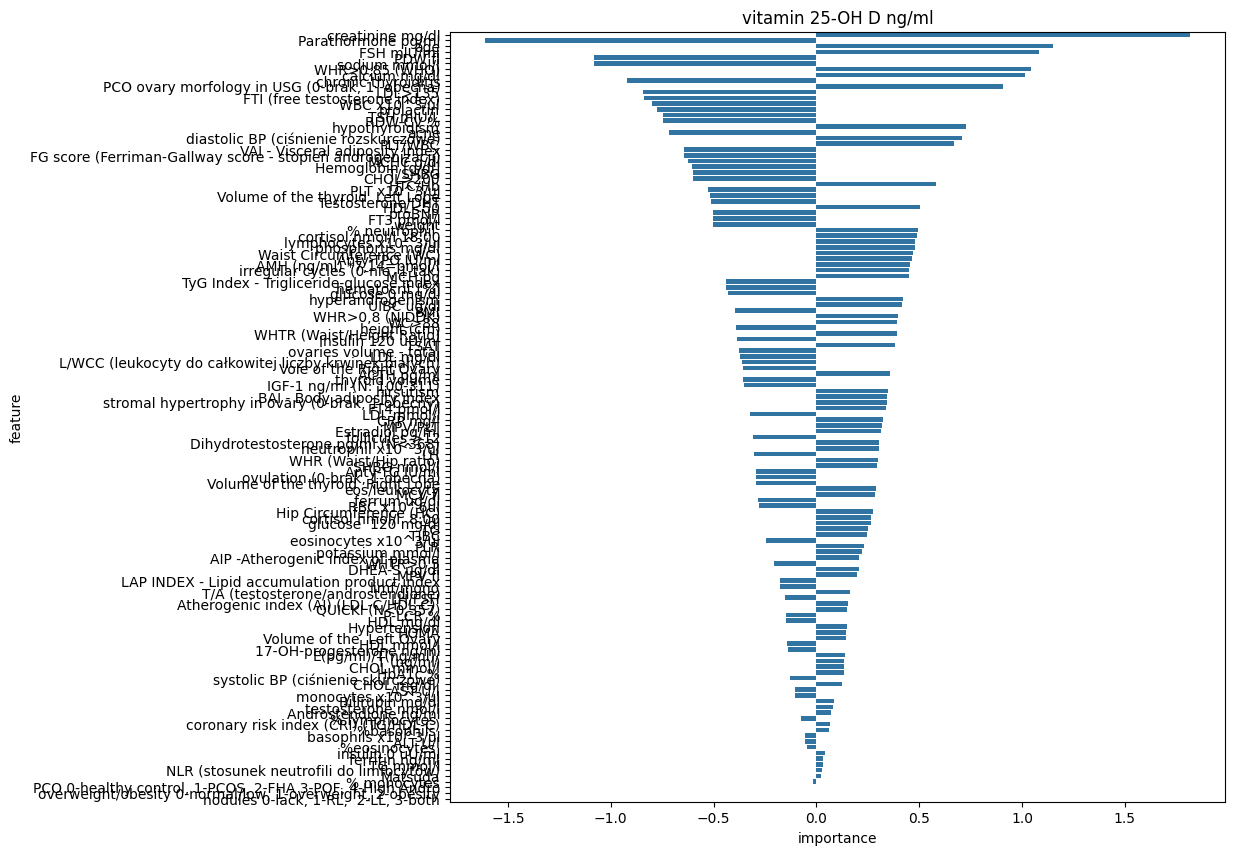

model  data_set      mse    mae    rmse     r2
0  Ridge(alpha=50)  training   81.824  7.217   9.046  0.335
1  Ridge(alpha=50)      test  131.199  9.310  11.454  0.071

In [10]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

### Decision Tree

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


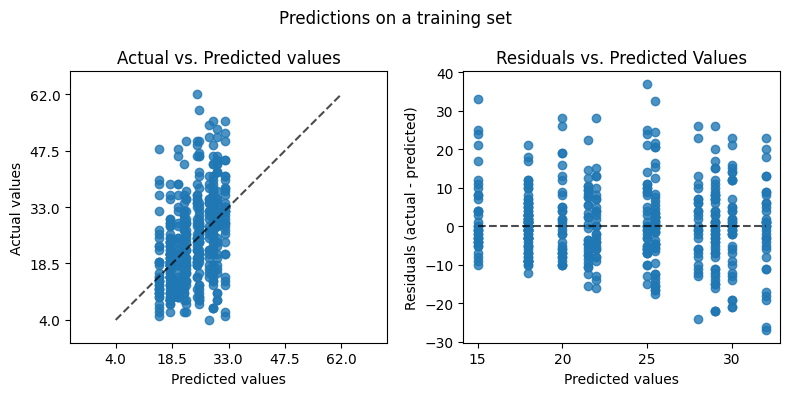

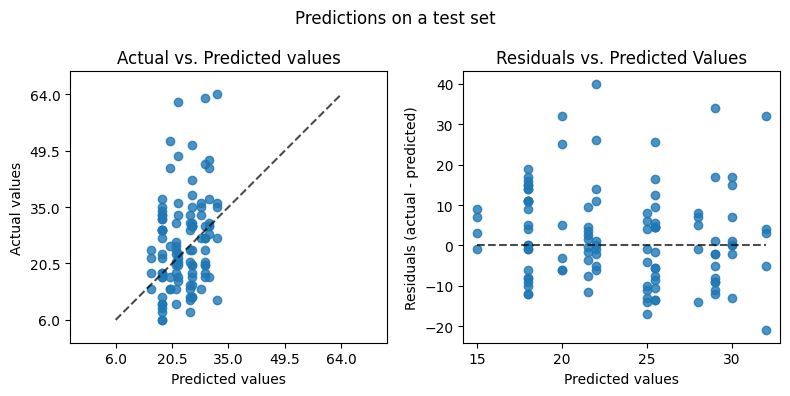

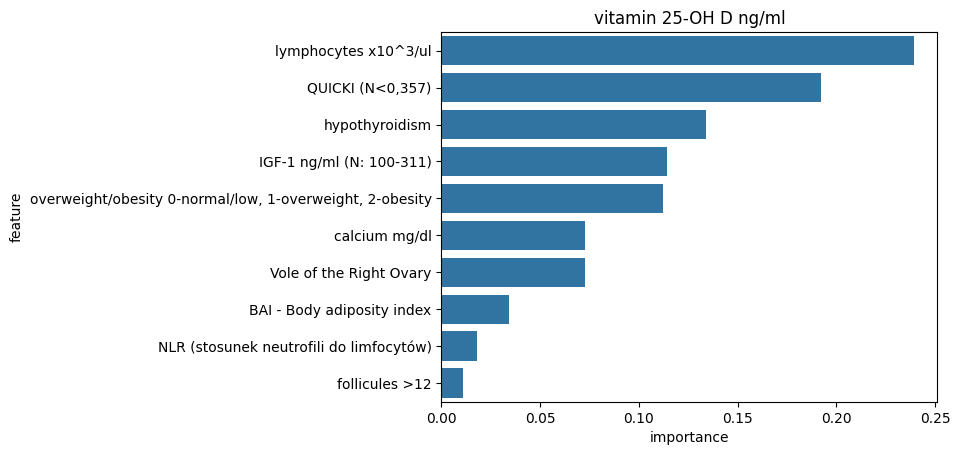

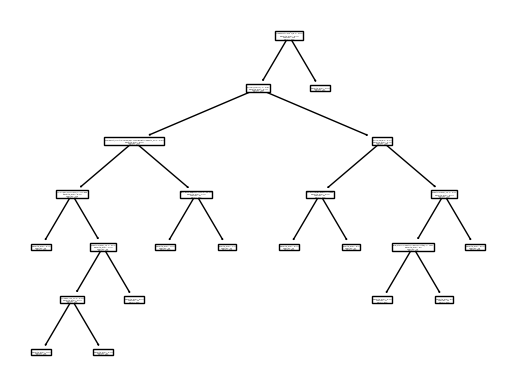

model  data_set      mse    mae    rmse     r2
0  DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n                      min_samples_leaf=27, min_samples_split=17,\n                      random_state=62, splitter='random')  training  104.483  7.709  10.222  0.151
1  DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n                      min_samples_leaf=27, min_samples_split=17,\n                      random_state=62, splitter='random')      test  138.646  8.959  11.775  0.018

In [11]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


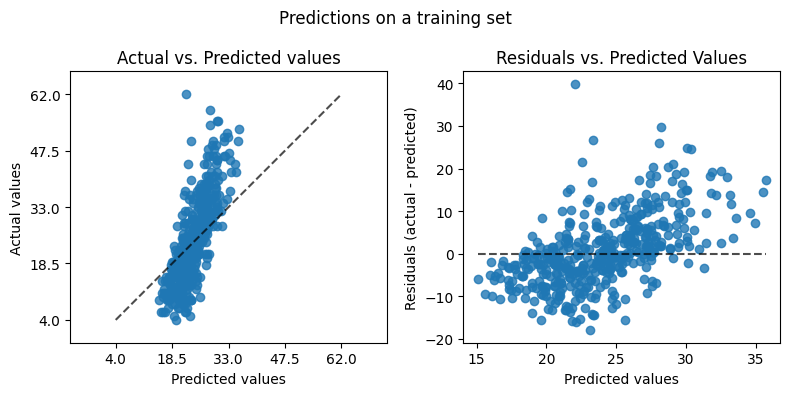

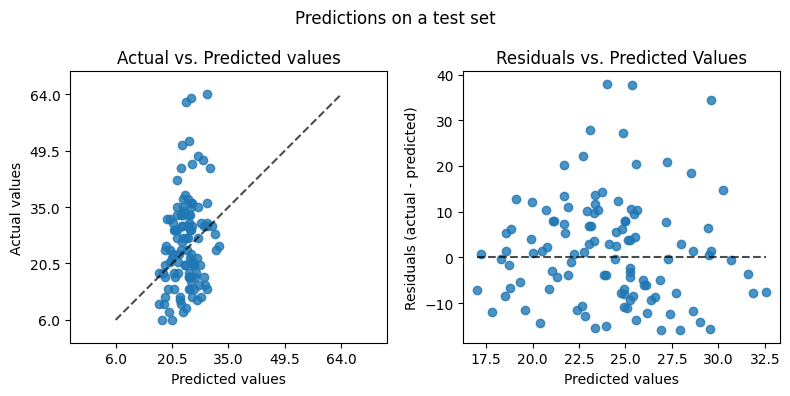

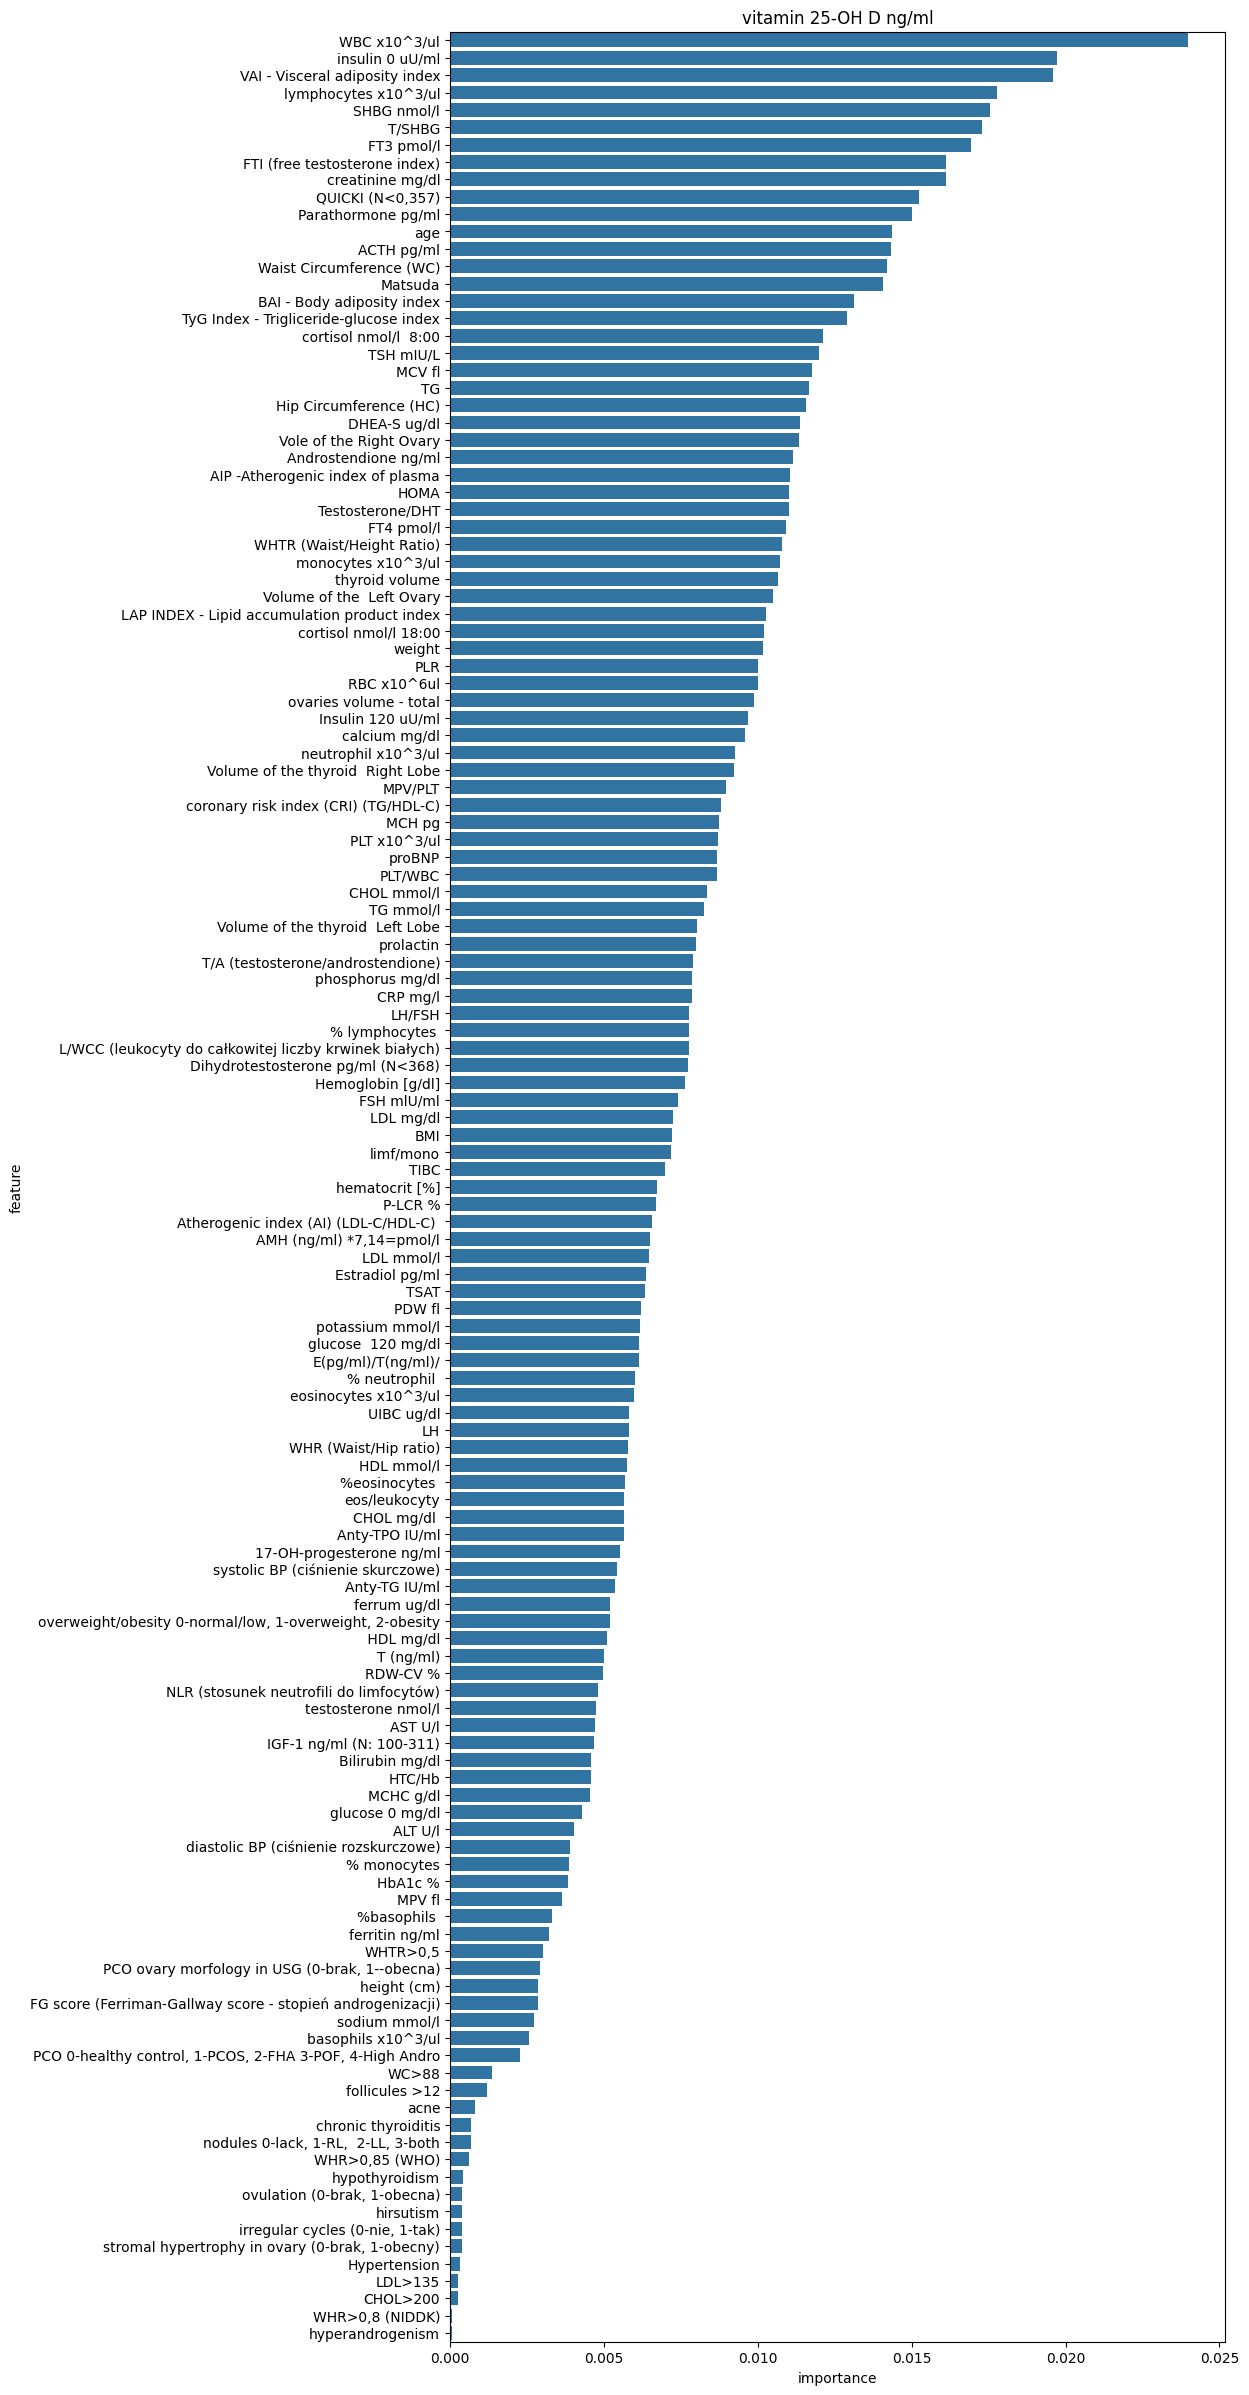

model  data_set      mse    mae    rmse     r2
0  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)  training   70.981  6.401   8.425  0.423
1  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)      test  135.235  9.051  11.629  0.042

In [12]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

## Feature importances based on Models


#### Original features

In [ ]:
#  method: features
selected_features_map = {}

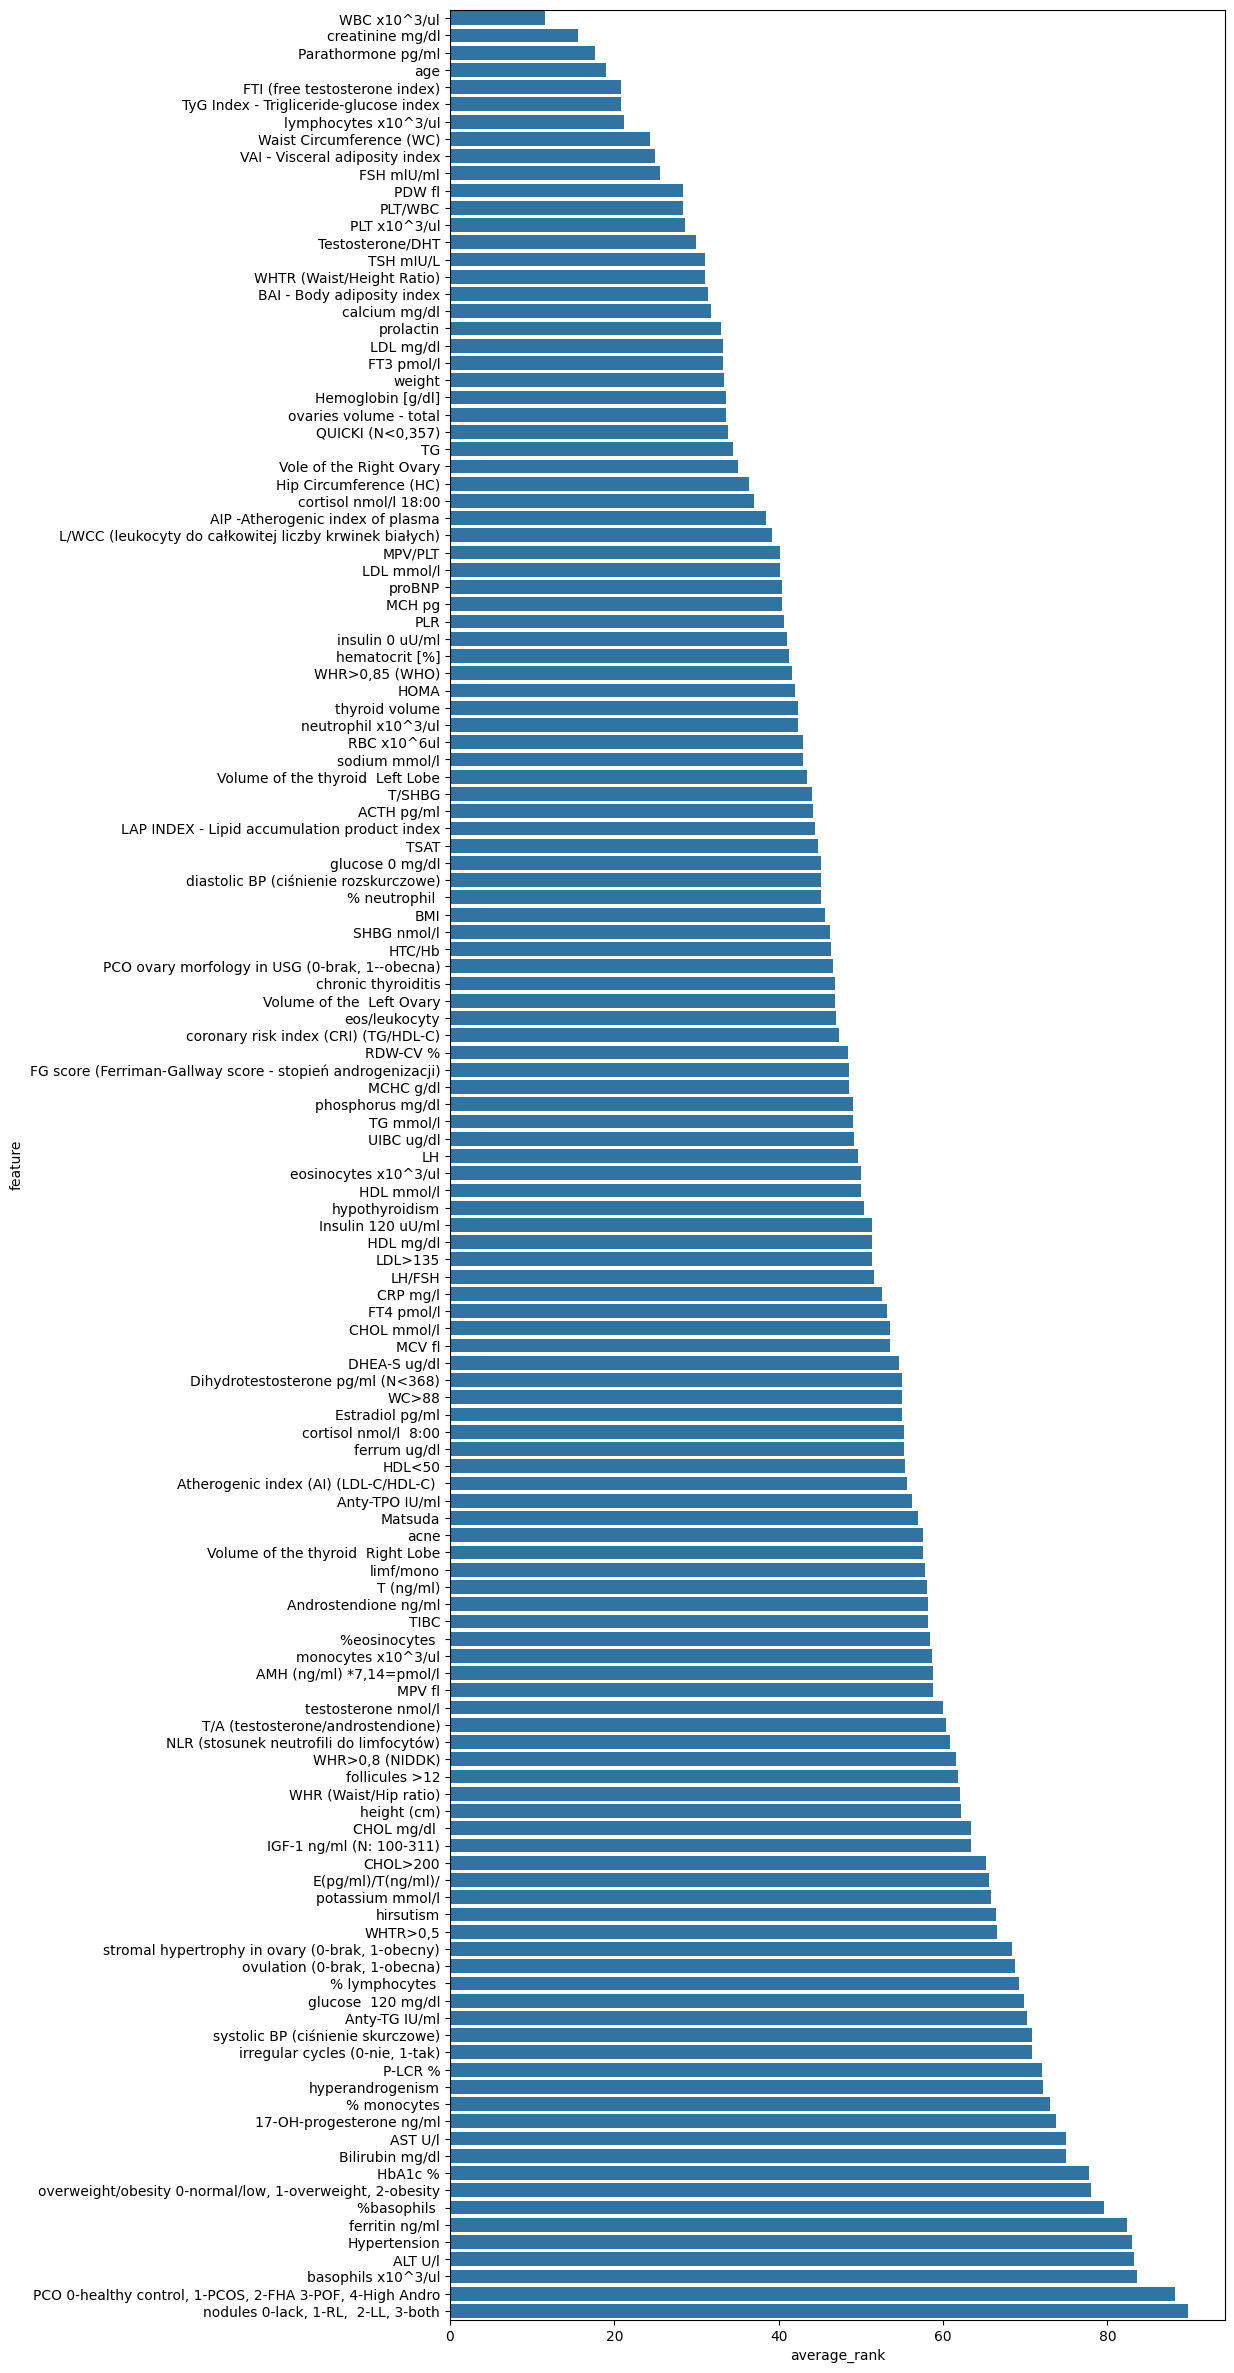

In [13]:
rename_importnace_col(feature_importnces_lr, 'linear_regression')
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'random_forest')

feature_importance_df = merge_feature_importances([feature_importnces_lr, feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])

ranked_df = rank_importances(feature_importance_df)
ranked_df_sorted = ranked_df.sort_values(by='average_rank')

plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

In [14]:
overall_rank_top_features = ranked_df_sorted[ranked_df_sorted['average_rank'] < 50] # a cut found on the plot above
overall_rank_selected_features = list(overall_rank_top_features['feature'].values)

selected_features_map['average_rank'] = overall_rank_selected_features
print(f'Top {len(overall_rank_selected_features)} features:')
overall_rank_selected_features

Top 67 features:


['WBC x10^3/ul',
 'creatinine mg/dl',
 'Parathormone pg/ml',
 'age',
 'FTI (free testosterone index)',
 'TyG Index - Trigliceride-glucose index',
 'lymphocytes x10^3/ul',
 'Waist Circumference (WC)',
 'VAI - Visceral adiposity index',
 'FSH mlU/ml',
 'PDW fl',
 'PLT/WBC',
 'PLT x10^3/ul',
 'Testosterone/DHT',
 'TSH mIU/L',
 'WHTR (Waist/Height Ratio)',
 'BAI - Body adiposity index',
 'calcium mg/dl',
 'prolactin',
 'LDL mg/dl',
 'FT3 pmol/l',
 'weight',
 'Hemoglobin [g/dl]',
 'ovaries volume - total',
 'QUICKI (N<0,357)',
 'TG',
 'Vole of the Right Ovary',
 'Hip Circumference (HC)',
 'cortisol nmol/l 18:00',
 'AIP -Atherogenic index of plasma',
 'L/WCC (leukocyty do całkowitej liczby krwinek białych)',
 'MPV/PLT',
 'LDL mmol/l',
 'proBNP',
 'MCH pg',
 'PLR',
 'insulin 0 uU/ml',
 'hematocrit [%]',
 'WHR>0,85 (WHO)',
 'HOMA',
 'thyroid volume',
 'neutrophil x10^3/ul',
 'RBC x10^6ul',
 'sodium mmol/l',
 'Volume of the thyroid  Left Lobe',
 'T/SHBG',
 'ACTH pg/ml',
 'LAP INDEX - Lipid accu

In [15]:
# overall_rank_top_features = ranked_df_sorted[ranked_df_sorted['average_rank'] < 37] # a cut found on the plot above
# overall_rank_selected_features = list(overall_rank_top_features['feature'].values)

# selected_features_map['average_rank'] = overall_rank_selected_features
# print(f'Top {len(overall_rank_selected_features)} features:')
# overall_rank_selected_features

#### Poly features

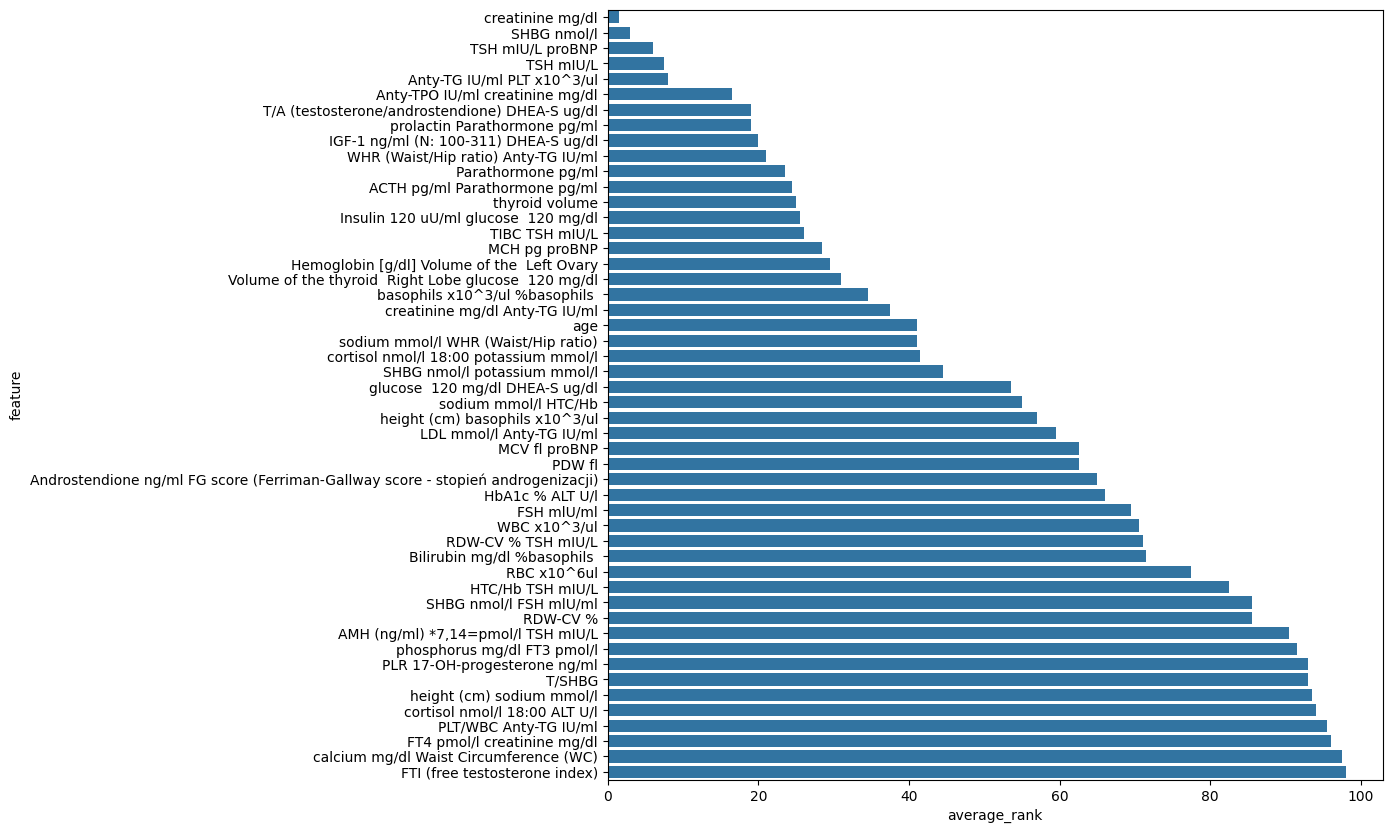

In [16]:
rename_importnace_col(feature_importnces_lr_poly, 'linear_regression_poly')
rename_importnace_col(feature_importnces_lasso_poly, 'lasso_poly')

feature_importance_poly_df = merge_feature_importances([feature_importnces_lr_poly, feature_importnces_lasso_poly])
ranked_df_poly = rank_importances(feature_importance_poly_df)
ranked_df_poly_sorted = ranked_df_poly.sort_values(by='average_rank')

plt.figure(figsize=(10, 10))
sns.barplot(ranked_df_poly_sorted.head(50), x="average_rank", y="feature")
plt.show()

In [17]:
# overall_rank_top_poly_features = ranked_df_poly_sorted[ranked_df_poly_sorted['average_rank'] < 27] # a cut found on the plot above
# overall_rank_selected_poly_features = list(overall_rank_top_poly_features['feature'].values)

# selected_features_map['average_rank_poly'] = overall_rank_selected_poly_features

# print(f'Top {len(overall_rank_selected_poly_features)} polynomial features:')
# overall_rank_selected_poly_features

Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)', `WBC x10^3/ul	`, `calcium mg/dl	`, `age`

## Feature selection methods

### Mutual info

In [33]:
selected_feature_names_mutual_info

feature  importance
0                                                       PDW fl    0.084689
1                                                  RBC x10^6ul    0.083319
2                                       Hip Circumference (HC)    0.080107
3                                     IGF-1 ng/ml (N: 100-311)    0.080039
4   FG score (Ferriman-Gallway score - stopień androgenizacji)    0.078998
5                                     AMH (ng/ml) *7,14=pmol/l    0.073168
6                                                          BMI    0.072788
7                                                   HDL mmol/l    0.066969
8                                                      PLT/WBC    0.063457
9                                FTI (free testosterone index)    0.060821
10                                          basophils x10^3/ul    0.058859
11                                                   HDL mg/dl    0.056782
12                LAP INDEX - Lipid accumulation product index    0.053842
13                         nodules 0-lack, 1-RL,  2-LL, 3-both    0.052206
14                                             Estradiol pg/ml    0.051795
15                                                 % monocytes    0.049049
16                                        Androstendione ng/ml    0.047399
17                                              Anty-TPO IU/ml    0.045766
18                                          monocytes x10^3/ul    0.044868
19                                                        TSAT    0.042858
20                                                      proBNP    0.040437
21                                                     HbA1c %    0.037807
22                                              WHR>0,85 (WHO)    0.037757
23                                         chronic thyroiditis    0.037388
24                                                     P-LCR %    0.036631
25                                         testosterone nmol/l    0.036358
26                                          Parathormone pg/ml    0.036339
27                           Volume of the thyroid  Right Lobe    0.036008
28                                                      T/SHBG    0.035876
29    overweight/obesity 0-normal/low, 1-overweight, 2-obesity    0.034999
30                                     Vole of the Right Ovary    0.033199
31                                               Anty-TG IU/ml    0.033092
32                                                         age    0.033029
33                                            phosphorus mg/dl    0.032838
34                                                WBC x10^3/ul    0.032003
35                                                      MPV fl    0.029935
36                                    17-OH-progesterone ng/ml    0.027259
37                             irregular cycles (0-nie, 1-tak)    0.024318
38                                                  FSH mlU/ml    0.023410
39                                          glucose  120 mg/dl    0.023284
40                                                       WC>88    0.023212
41                                                   TG mmol/l    0.023068
42                                                          TG    0.023024
43                                                   T (ng/ml)    0.022521
44                     NLR (stosunek neutrofili do limfocytów)    0.022172
45                                             insulin 0 uU/ml    0.021615
46                                              thyroid volume    0.017028
47                       Atherogenic index (AI) (LDL-C/HDL-C)     0.013474
48                                   Volume of the  Left Ovary    0.011329
49                                    Waist Circumference (WC)    0.010622
50                                              hypothyroidism    0.010612
51                                               eos/leukocyty    0.010450
52    PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro    0.009239
53   

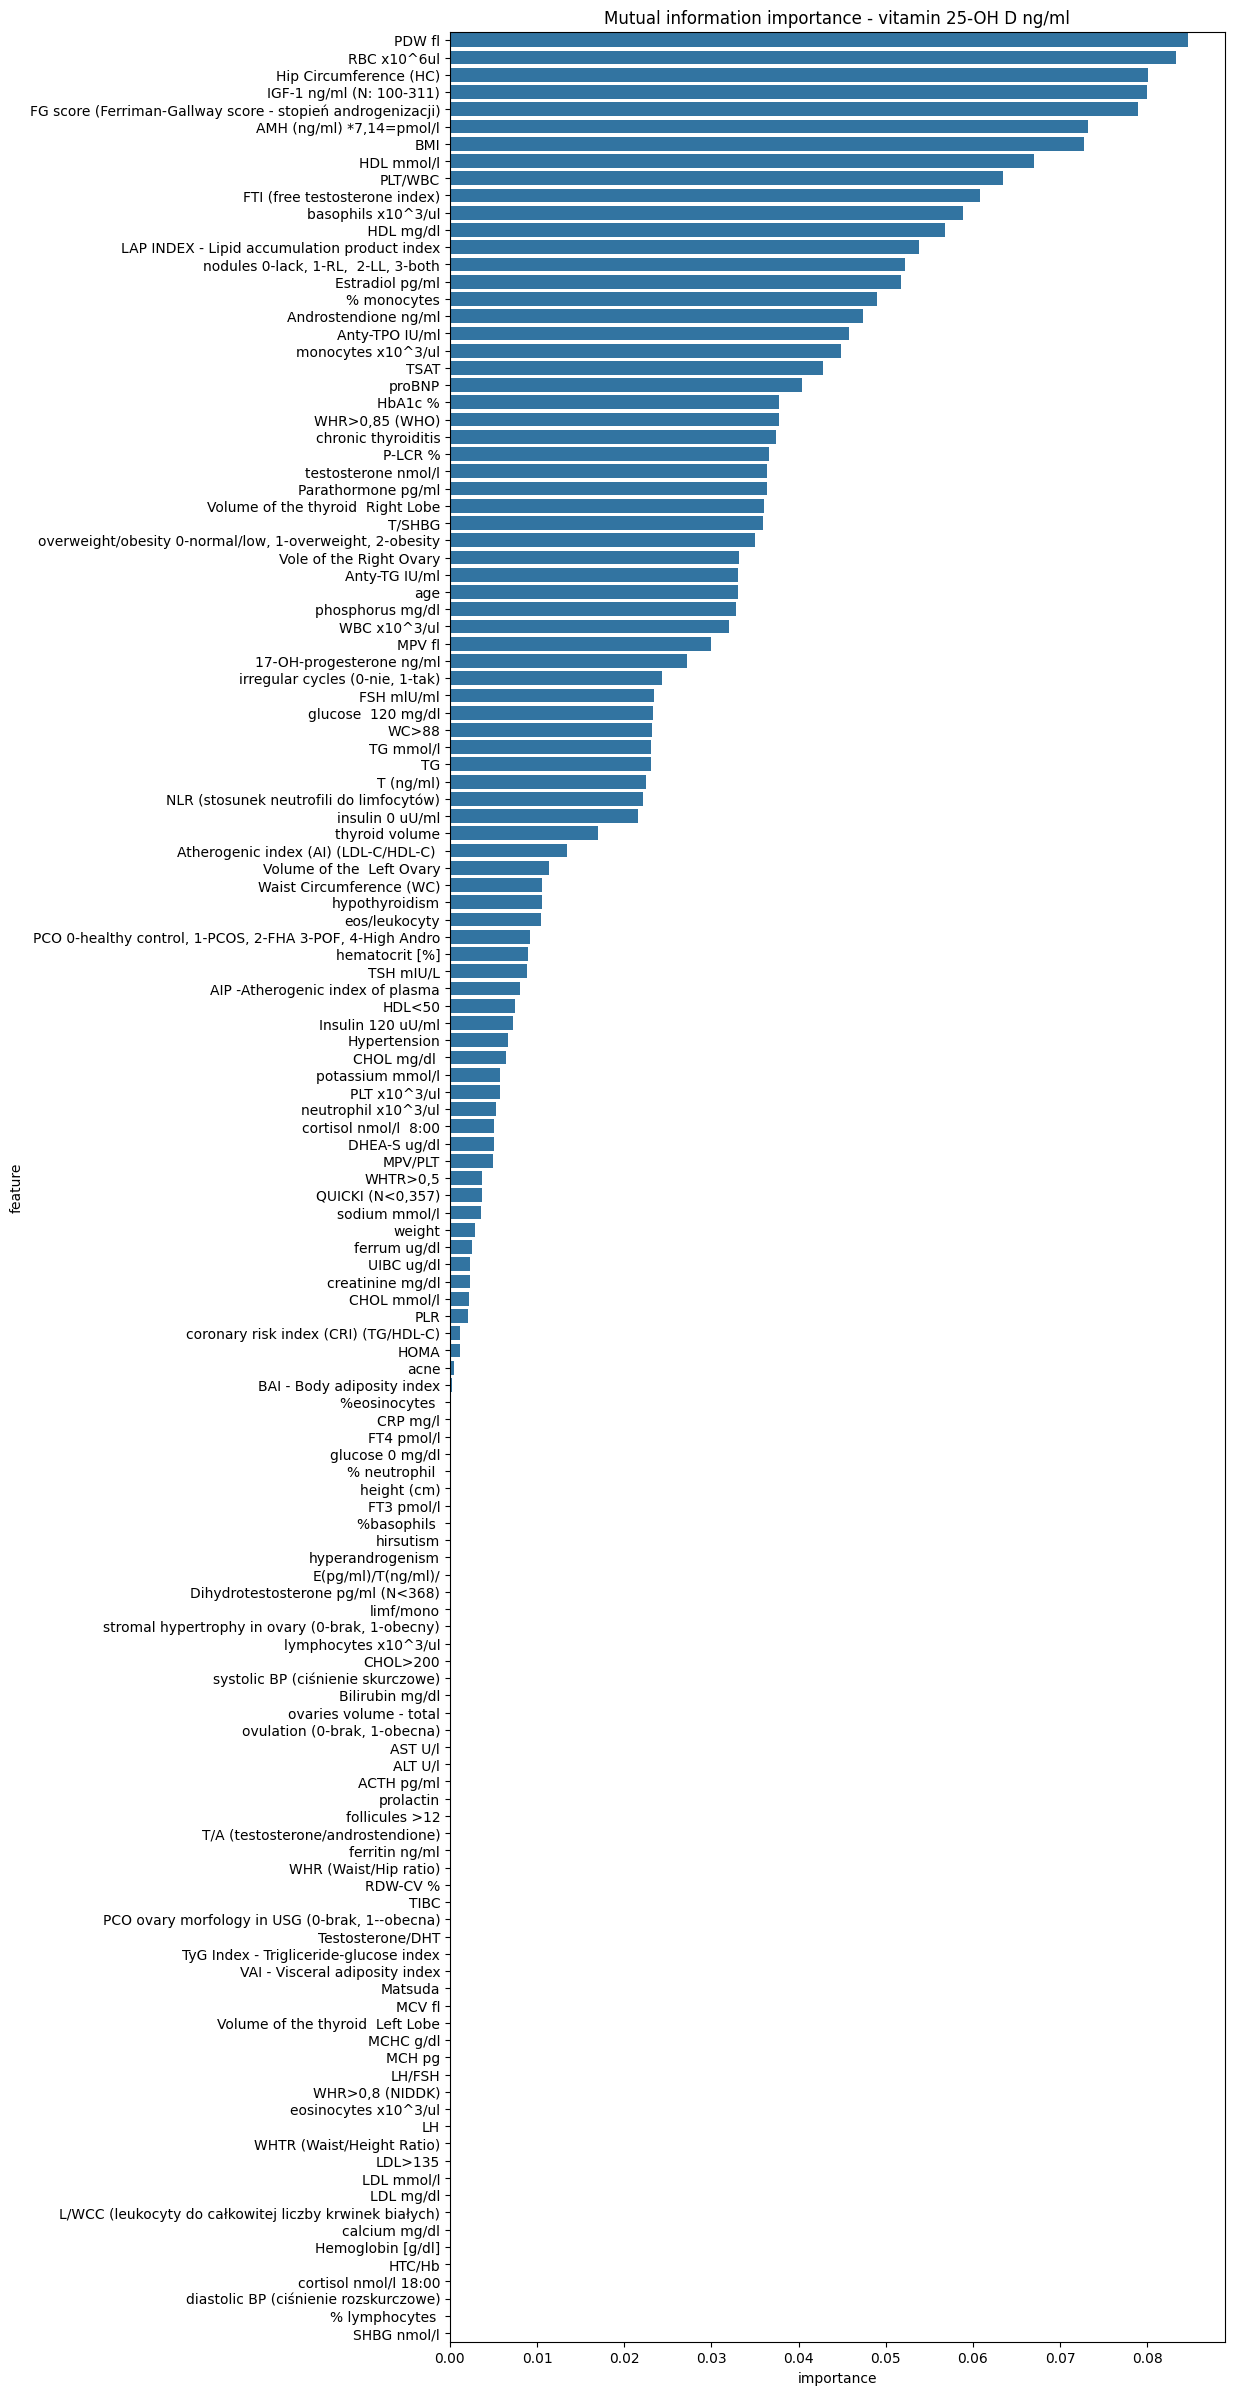

In [19]:
selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_vit_d, y_train_vit_d, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['importance'] > 0]
selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)

selected_features_map['mutual_info'] = list(selected_feature_names_mutual_info['feature'].values)
# selected_feature_names_mutual_info

### Recursive feature elimination

Optimal number of features: 37


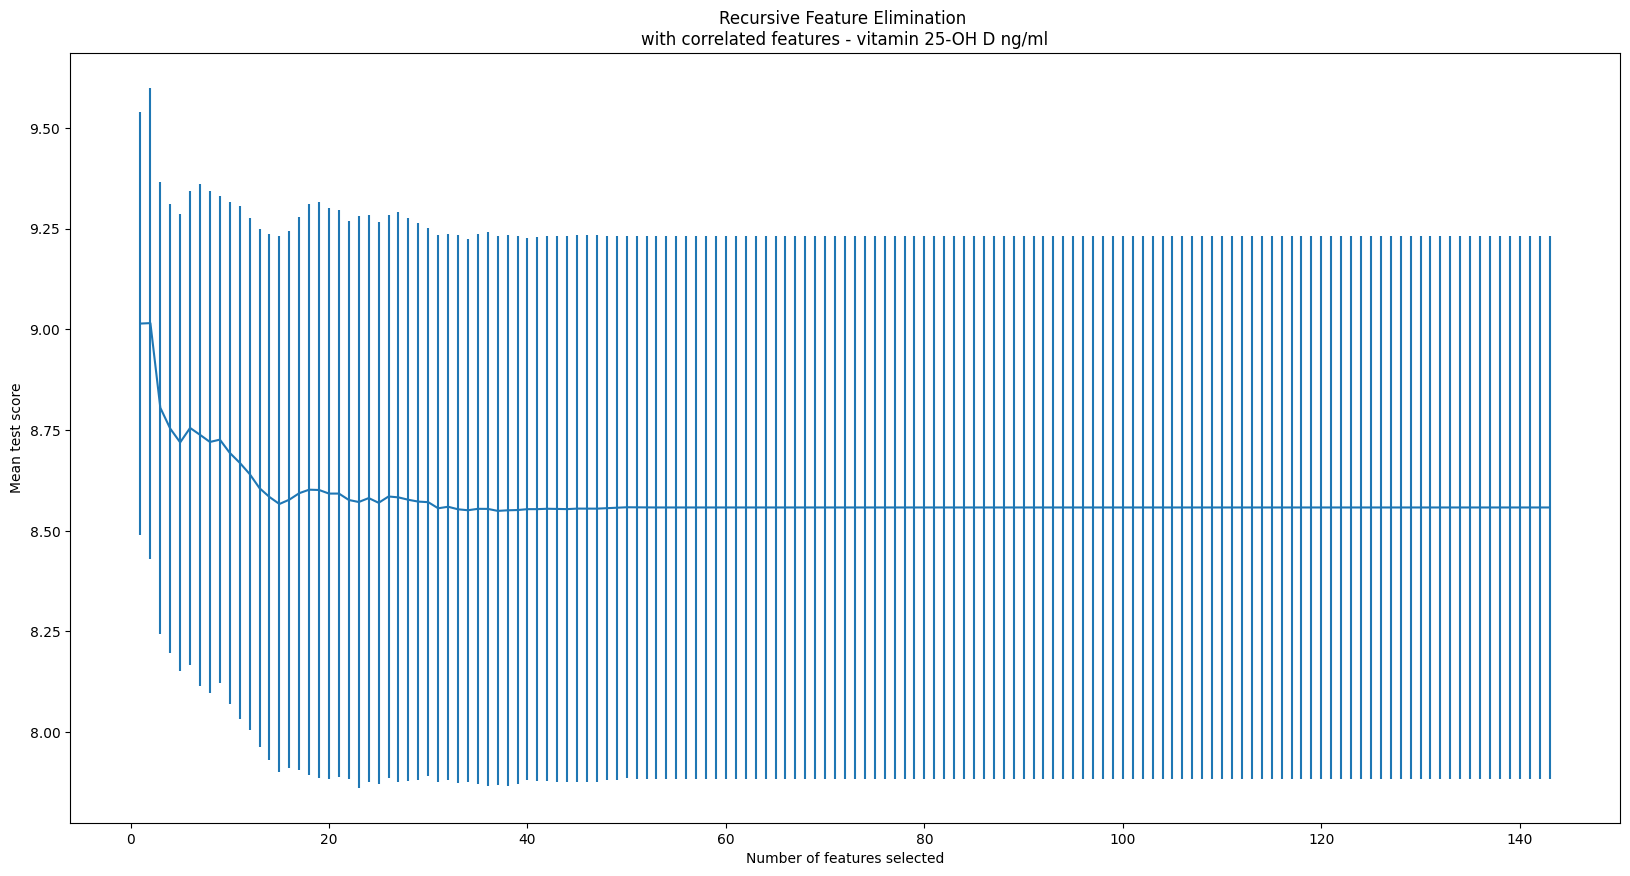

['RDW-CV %',
 'MCHC g/dl',
 'Dihydrotestosterone pg/ml (N<368)',
 'TyG Index - Trigliceride-glucose index',
 'Testosterone/DHT',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'FSH mlU/ml',
 'FT3 pmol/l',
 'FTI (free testosterone index)',
 'TSH mIU/L',
 'SHBG nmol/l',
 'thyroid volume',
 'RBC x10^6ul',
 'Parathormone pg/ml',
 'Hemoglobin [g/dl]',
 'PDW fl',
 'IGF-1 ng/ml (N: 100-311)',
 'Insulin 120 uU/ml',
 'Volume of the thyroid  Left Lobe',
 'WBC x10^3/ul',
 'LDL mg/dl',
 'acne',
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
 'ovaries volume - total',
 'height (cm)',
 'WHR>0,85 (WHO)',
 'diastolic BP (ciśnienie rozskurczowe)',
 '% neutrophil ',
 'phosphorus mg/dl',
 'creatinine mg/dl',
 'cortisol nmol/l  8:00',
 'prolactin',
 'calcium mg/dl',
 'sodium mmol/l',
 'age',
 'cortisol nmol/l 18:00',
 'proBNP']

In [20]:
lasso_model = Lasso(alpha=0.2)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_vit_d, y_train_vit_d, lasso_model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

### Permutation importance

selected 110 features


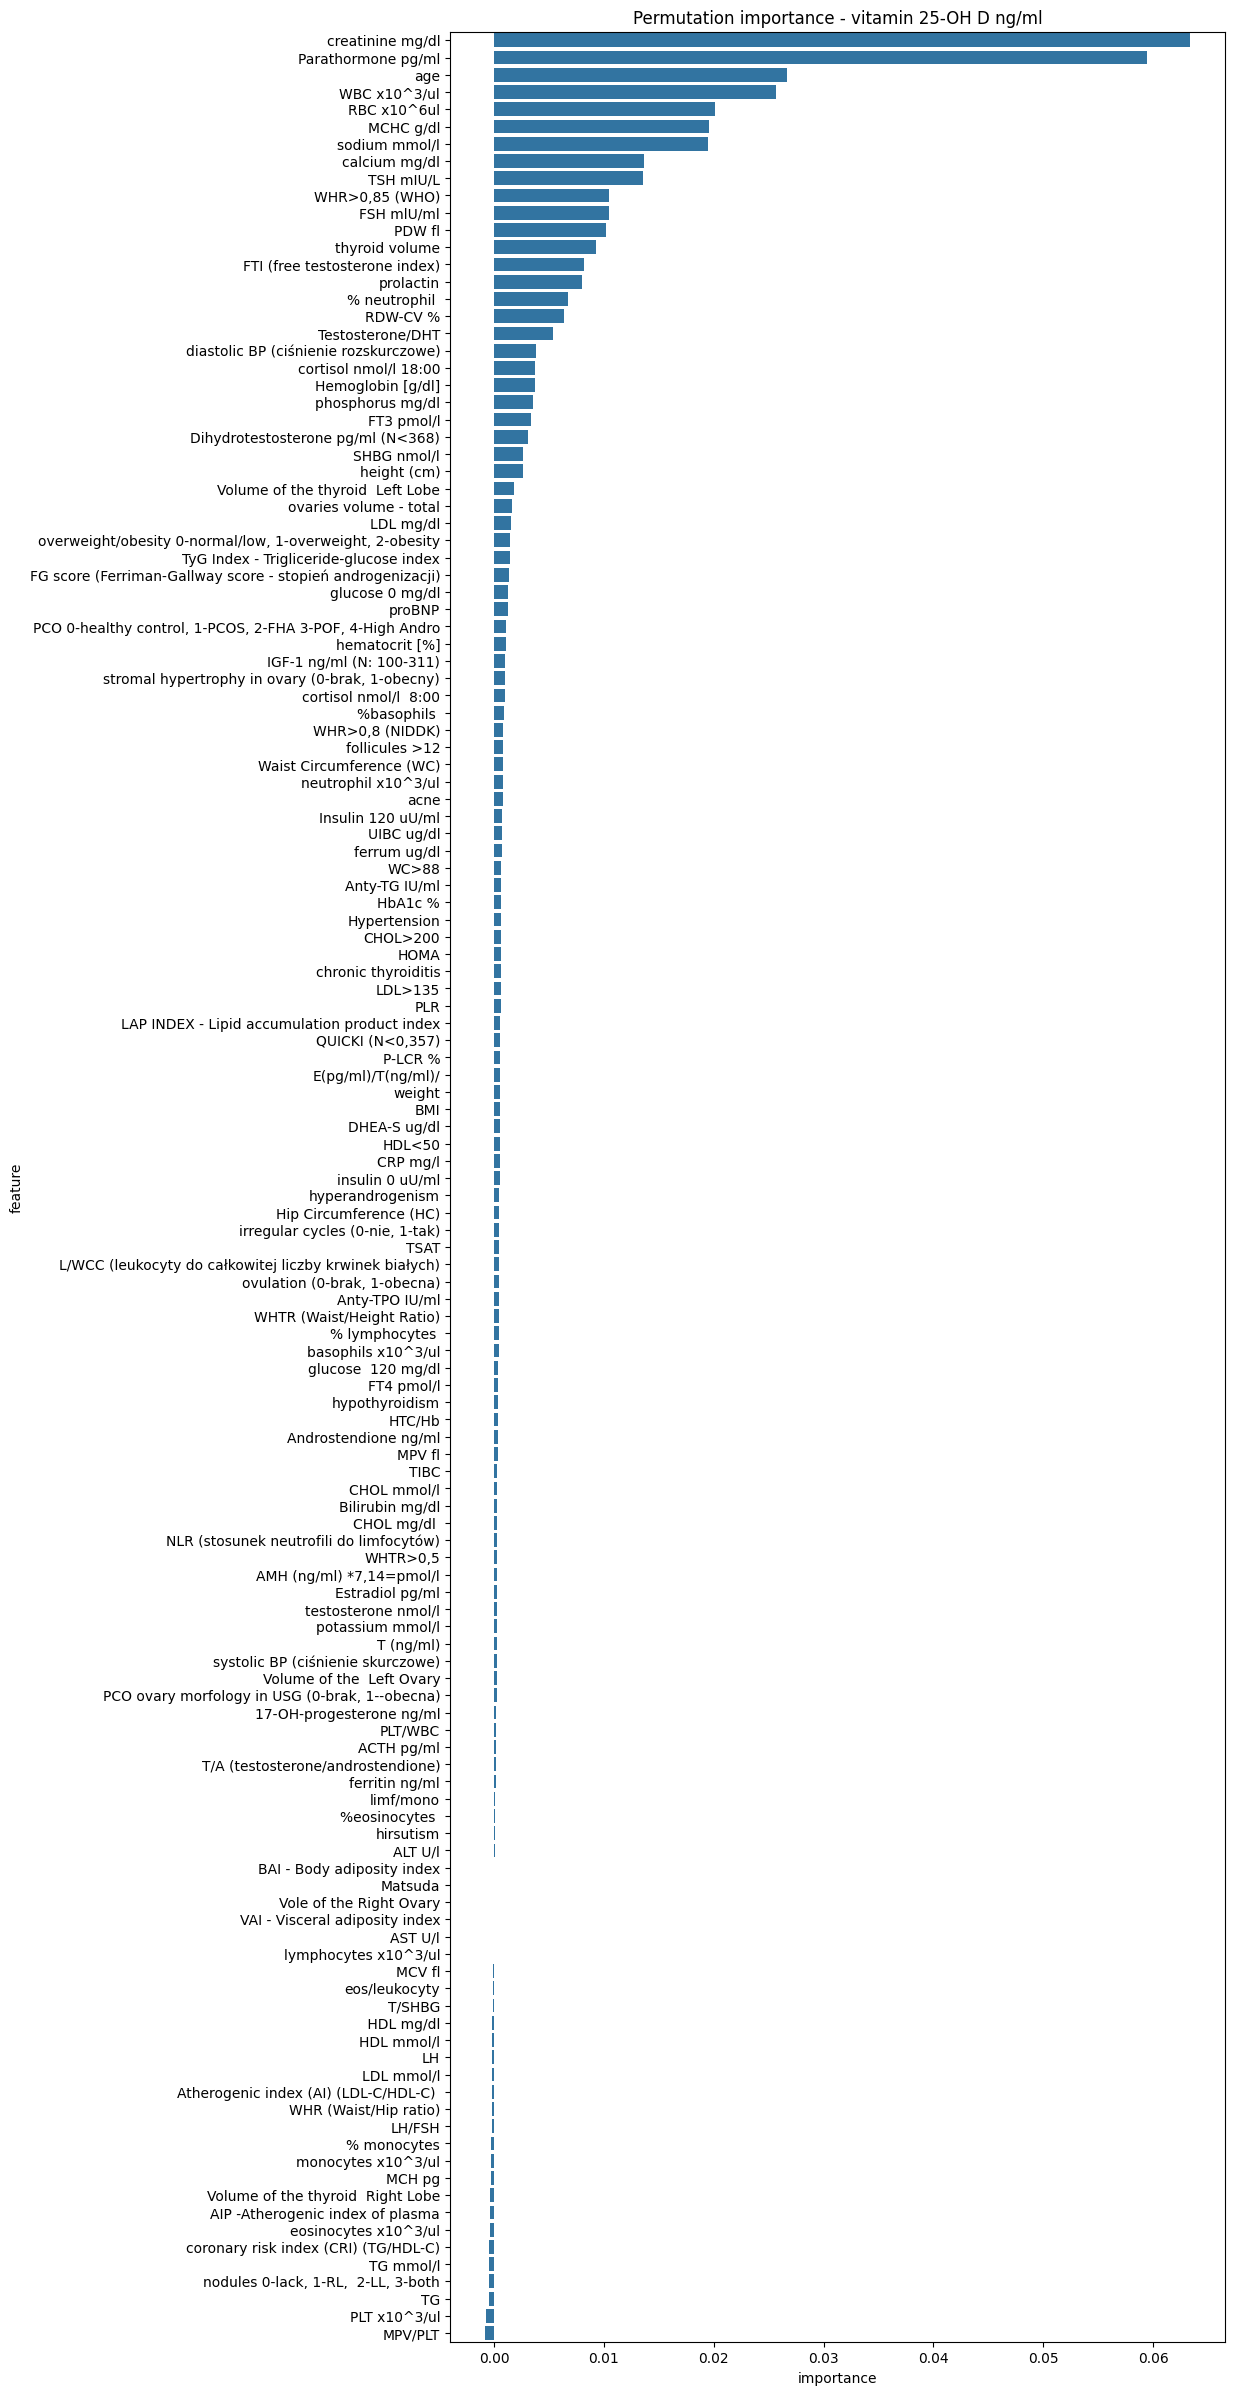

Actually selected 37 features


In [37]:
lasso_model = Lasso(alpha=0.2)

selected_features_permutation_importance = get_permutation_importance(X_train_vit_d, y_train_vit_d, lasso_model, continuous_preprocessor, categorical_preprocessor, VITAMINE_D)
selected_features_permutation_importance = selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0.001]
selected_features_map['permutation_importance'] = list(selected_features_permutation_importance['feature'].values)
# selected_features_map['permutation_importance'] = list(selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0.001]['feature'].values)
print(f'Actually selected {len(selected_features_map['permutation_importance'])} features')
# selected_features_permutation_importance

In [38]:
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

15
['phosphorus mg/dl', 'Parathormone pg/ml', 'WHR>0,85 (WHO)', 'FTI (free testosterone index)', 'proBNP', 'creatinine mg/dl', 'PDW fl', 'FSH mlU/ml', 'sodium mmol/l', 'WBC x10^3/ul', 'RBC x10^6ul', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'TSH mIU/L', 'age', 'thyroid volume']


0
0                                             phosphorus mg/dl
1                                           Parathormone pg/ml
2                                               WHR>0,85 (WHO)
3                                FTI (free testosterone index)
4                                                       proBNP
5                                             creatinine mg/dl
6                                                       PDW fl
7                                                   FSH mlU/ml
8                                                sodium mmol/l
9                                                 WBC x10^3/ul
10                                                 RBC x10^6ul
11  FG score (Ferriman-Gallway score - stopień androgenizacji)
12                                                   TSH mIU/L
13                                                         age
14                                              thyroid volume

In [39]:
union_all_sets = set(selected_features_map[next(iter(selected_features_map))]) 

for key, items in selected_features_map.items():
    union_all_sets.update(items)
    

union_all_sets = list(union_all_sets)
print(len(union_all_sets))
print(union_all_sets)

107
['RDW-CV %', 'height (cm)', 'HbA1c %', 'Hip Circumference (HC)', 'Vole of the Right Ovary', 'FTI (free testosterone index)', 'HOMA', '% neutrophil ', 'Testosterone/DHT', 'eos/leukocyty', 'WBC x10^3/ul', 'irregular cycles (0-nie, 1-tak)', 'cortisol nmol/l 18:00', 'Anty-TPO IU/ml', ' HDL mg/dl', 'P-LCR %', 'Insulin 120 uU/ml', 'LDL mg/dl', 'age', 'TyG Index - Trigliceride-glucose index', 'Dihydrotestosterone pg/ml (N<368)', 'PCO ovary morfology in USG (0-brak, 1--obecna)', 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'HDL mmol/l', 'thyroid volume', 'SHBG nmol/l', 'ACTH pg/ml', 'Hemoglobin [g/dl]', 'diastolic BP (ciśnienie rozskurczowe)', 'potassium mmol/l', 'VAI - Visceral adiposity index', 'weight', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'phosphorus mg/dl', 'insulin 0 uU/ml', 'Androstendione ng/ml', 'calcium mg/dl', 'basophils x10^3/ul', 'Volume of the thyroid  Right Lobe', 'hypothyroidism', 'MCH pg', 'sodium mmol/l', 'PLT/WBC', 'TG mmol/l', 'WHTR (Waist/Height Rati

## Test the narrowed down feature space

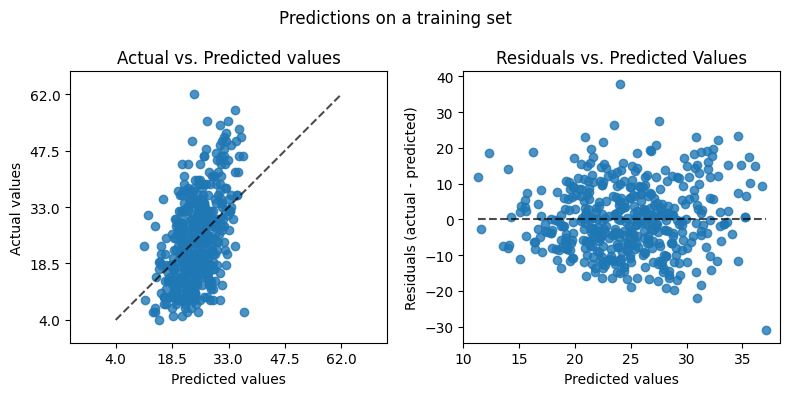

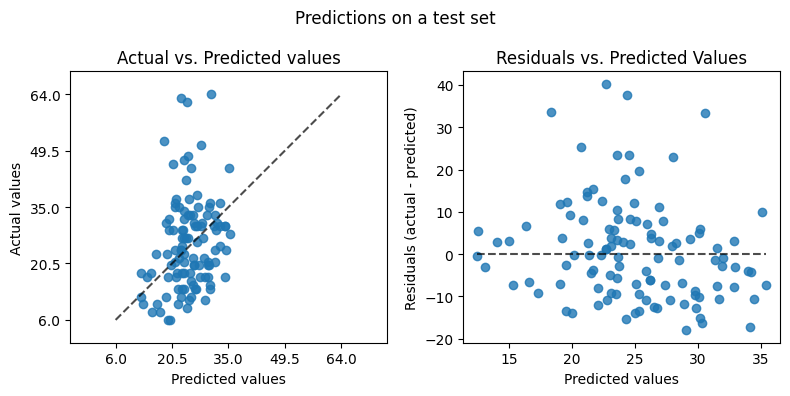

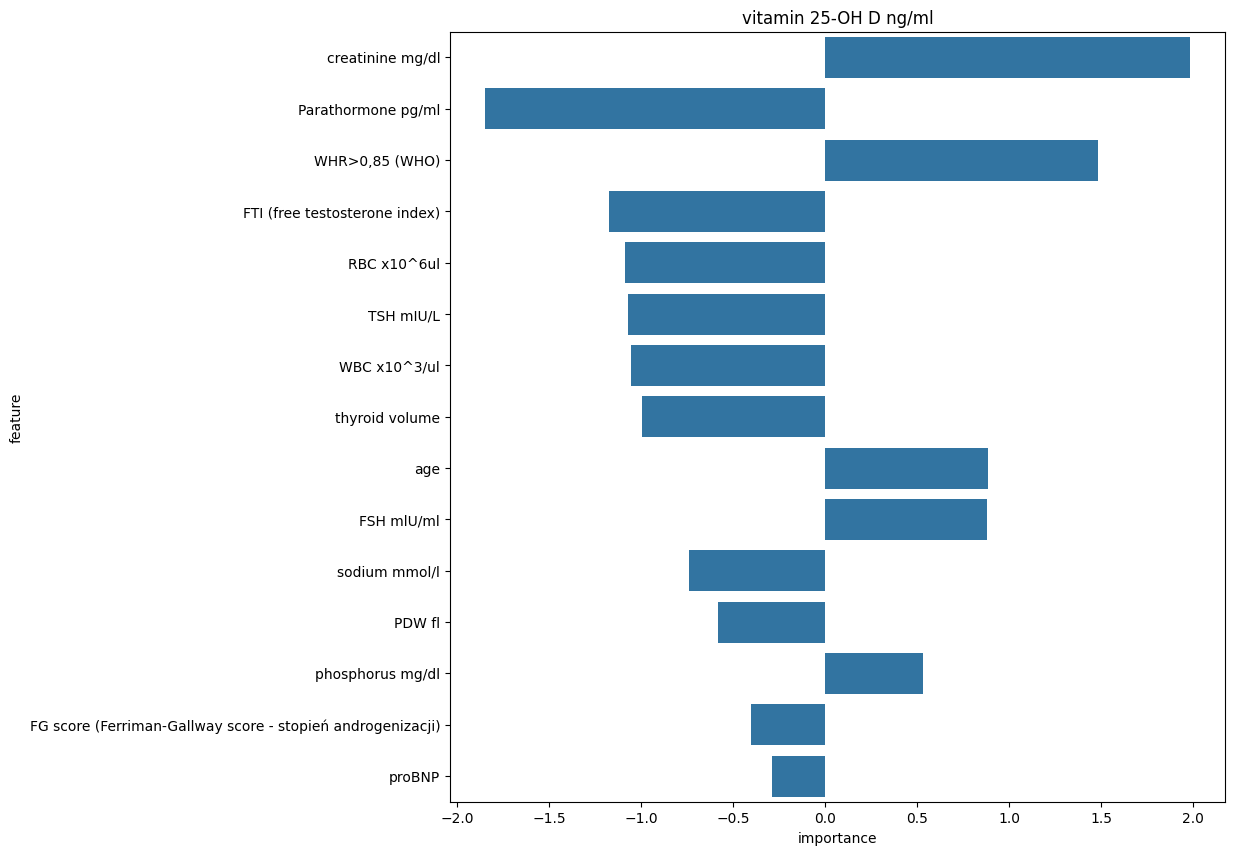

model  data_set      mse    mae    rmse     r2
0  Lasso(alpha=0.2)  training   94.213  7.783   9.706  0.235
1  Lasso(alpha=0.2)      test  140.000  9.034  11.832  0.008

In [40]:
lasso_model = Lasso(alpha=0.2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

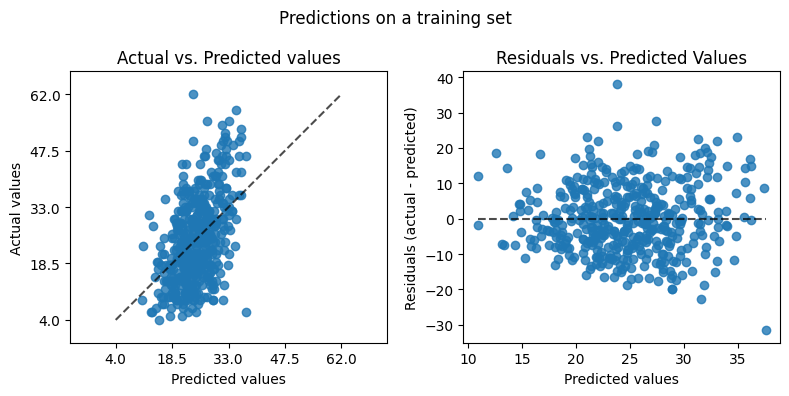

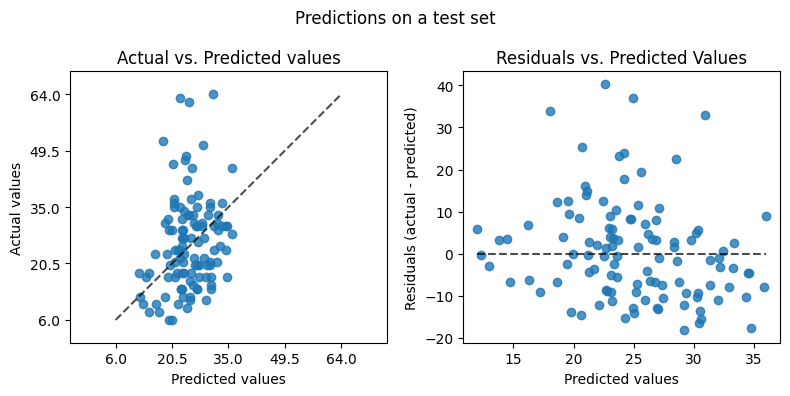

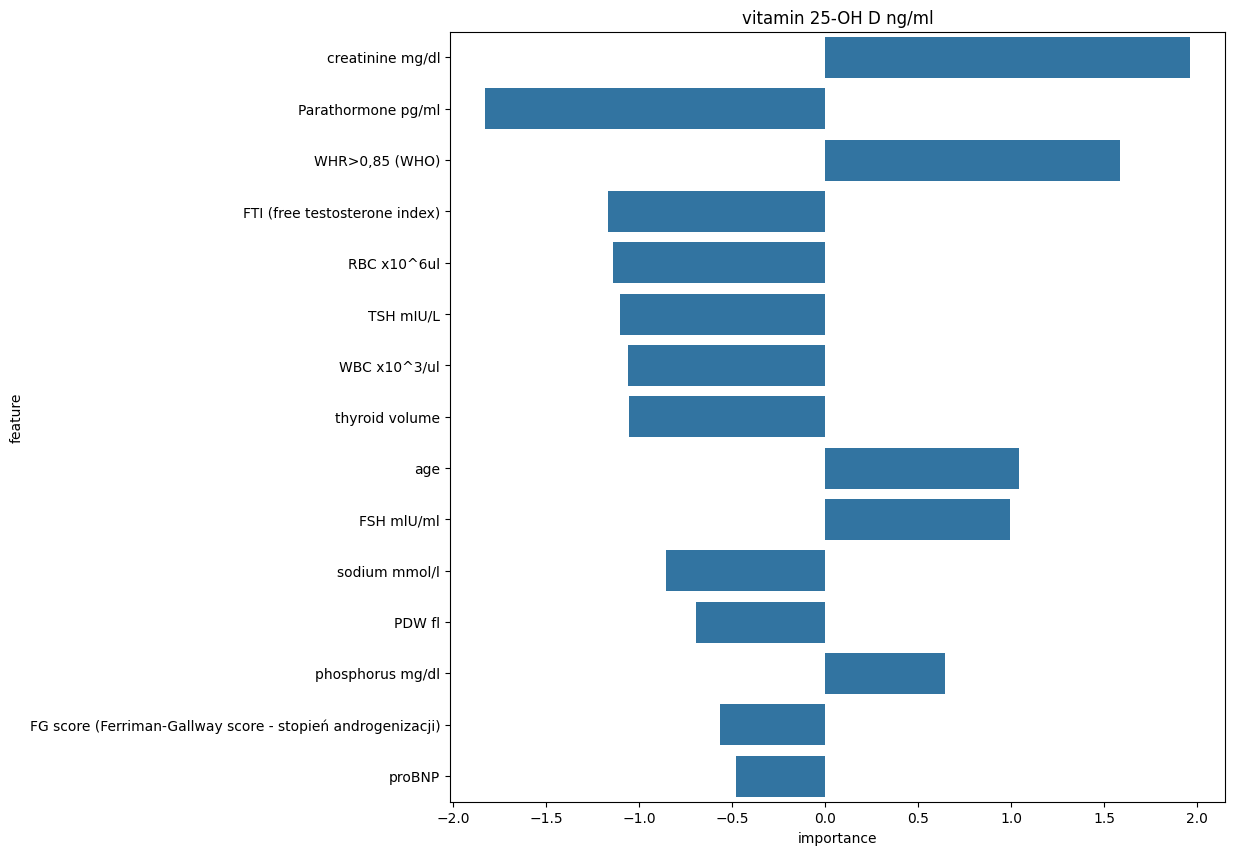

model  data_set      mse    mae    rmse     r2
0  Ridge(alpha=50)  training   93.870  7.757   9.689  0.238
1  Ridge(alpha=50)      test  140.964  9.089  11.873  0.002

In [41]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

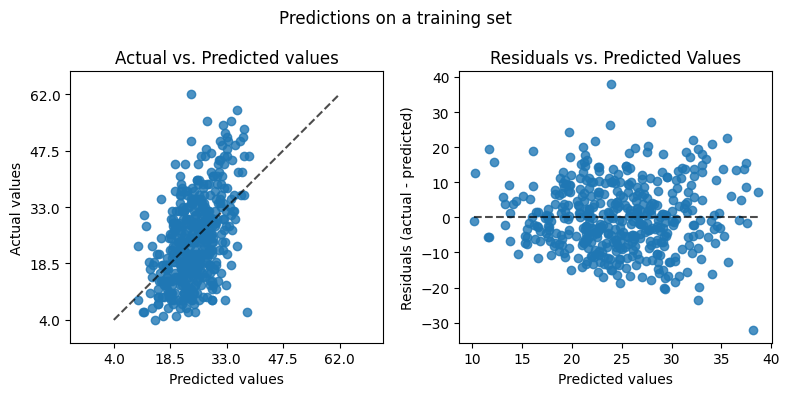

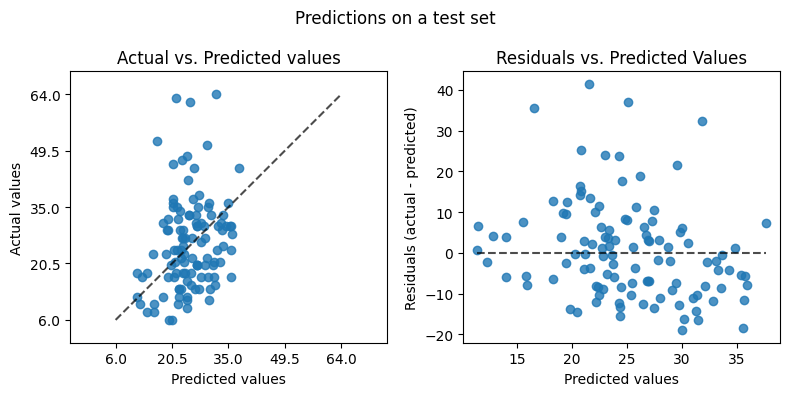

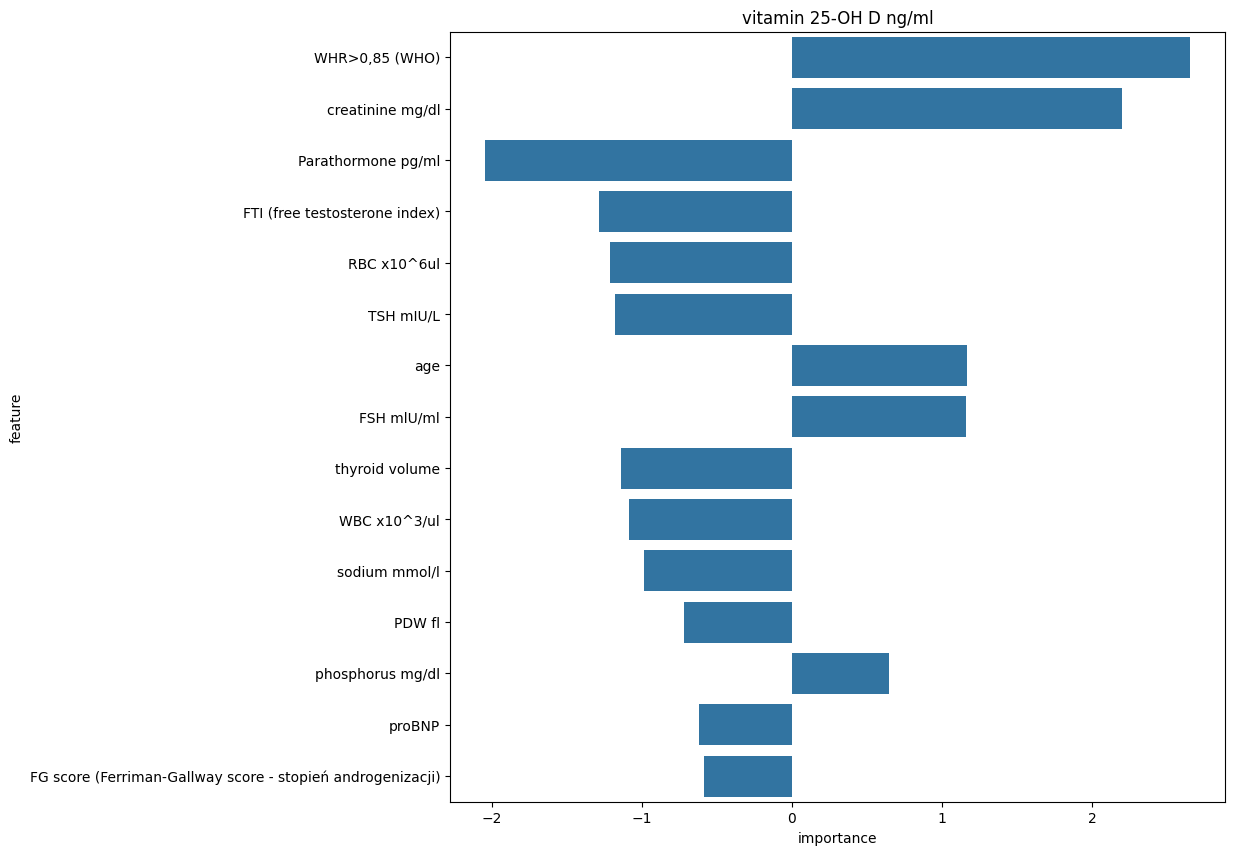

model  data_set      mse    mae    rmse     r2
0  LinearRegression()  training   93.479  7.736   9.668  0.241
1  LinearRegression()      test  143.505  9.188  11.979 -0.016

In [42]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

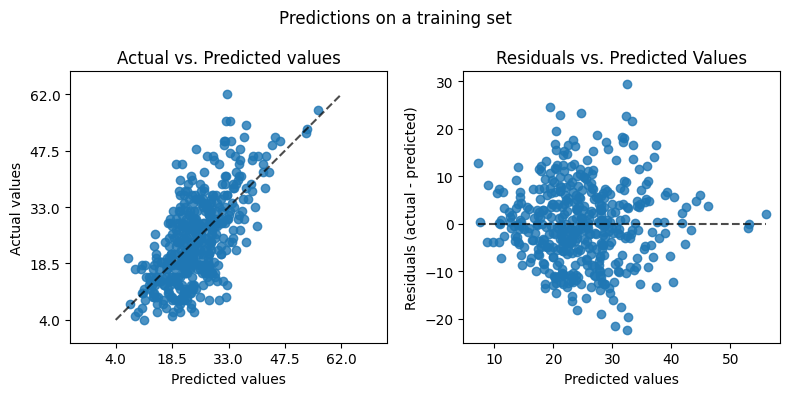

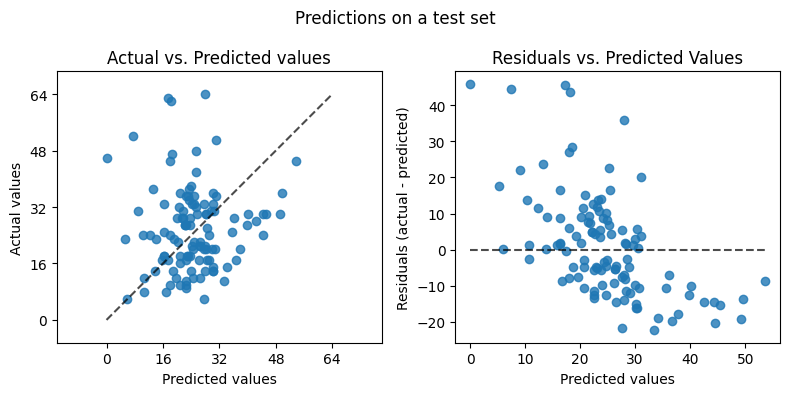

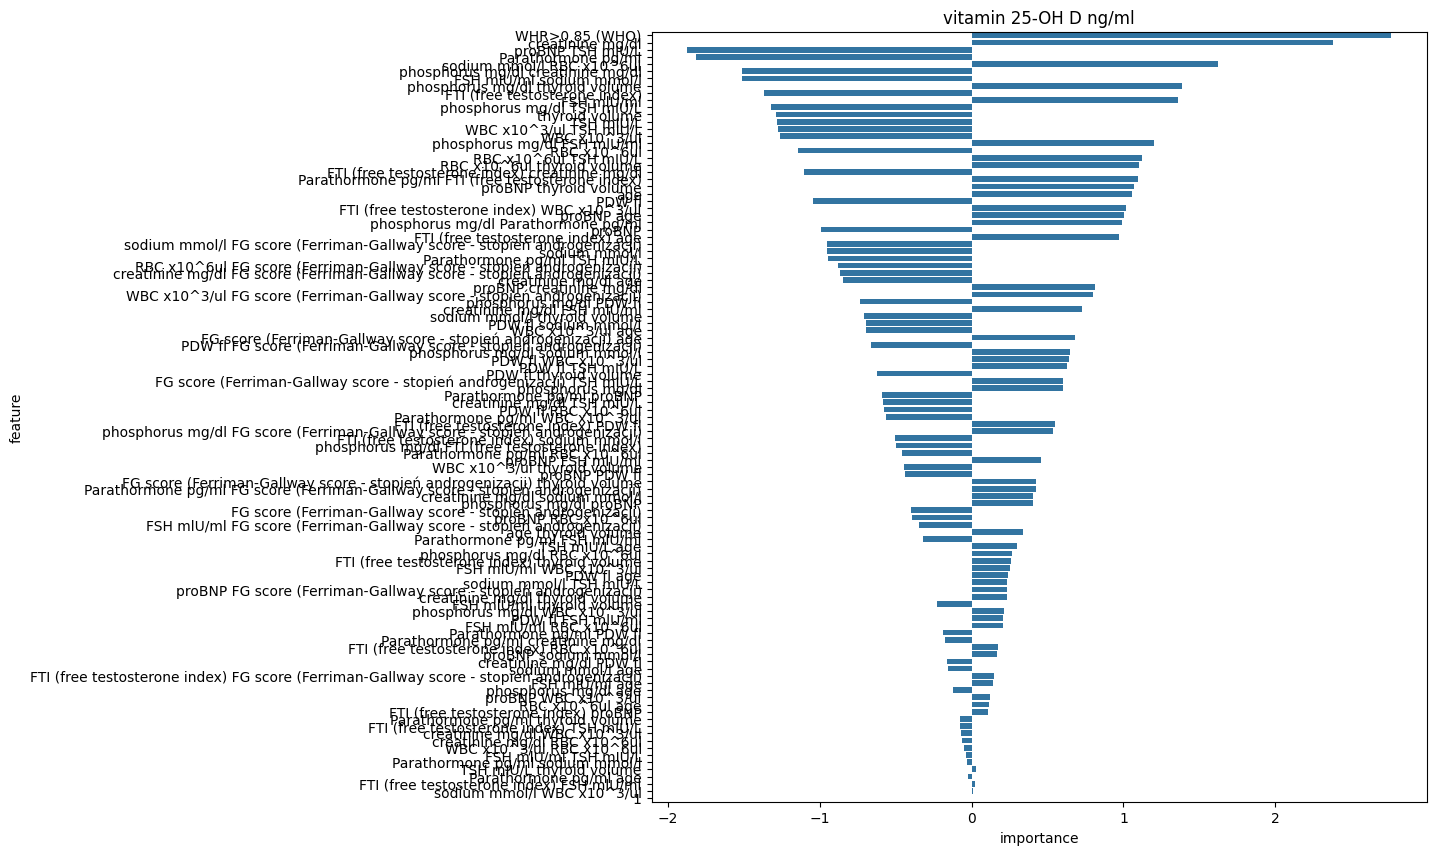

model  data_set      mse     mae    rmse     r2
0  LinearRegression()  training   69.355   6.536   8.328  0.437
1  LinearRegression()      test  213.520  11.202  14.612 -0.512

In [30]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr_poly = train_model(lr_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, linear_continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

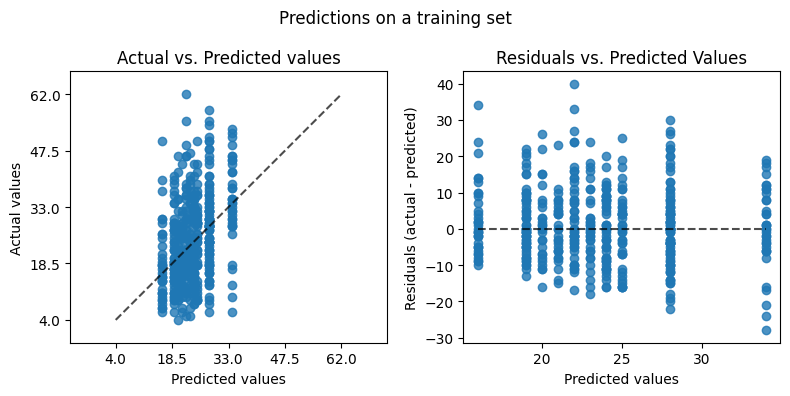

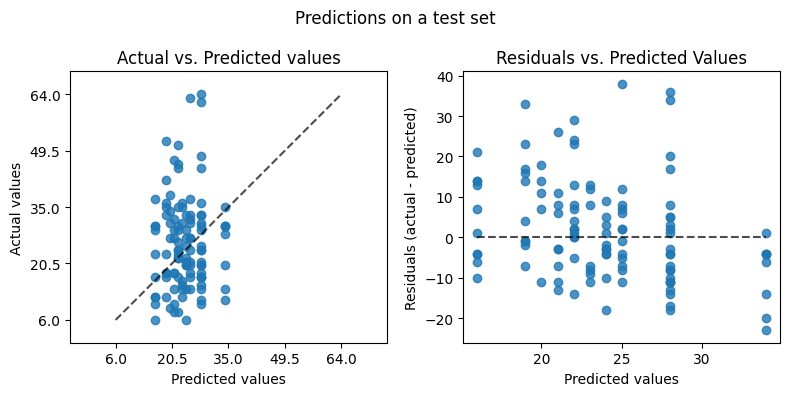

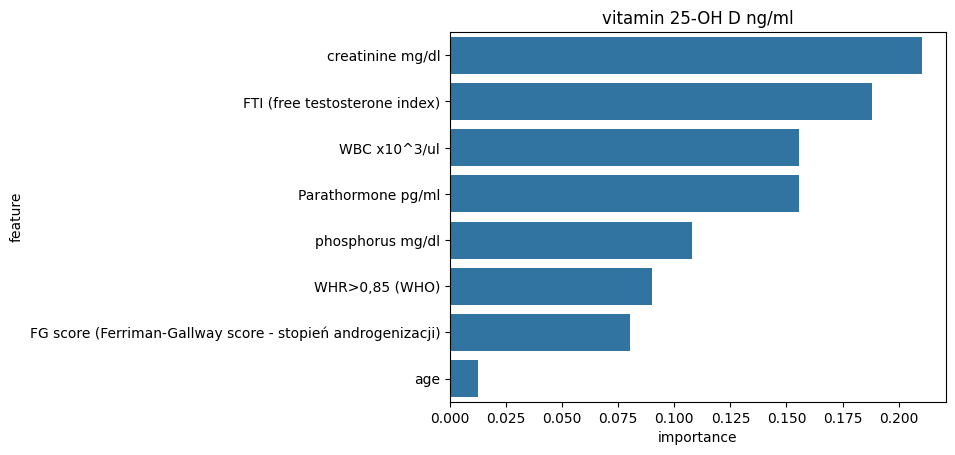

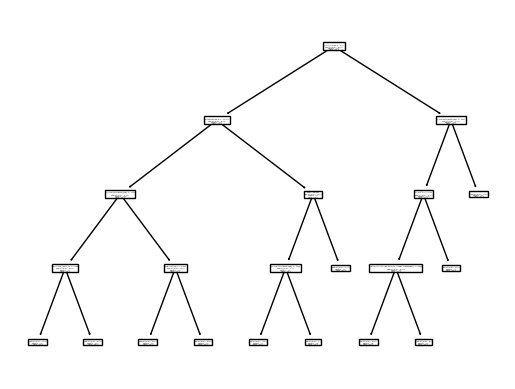

model  data_set      mse    mae    rmse     r2
0  DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n                      min_samples_leaf=27, min_samples_split=17,\n                      random_state=62, splitter='random')  training  108.677  8.054  10.425  0.117
1  DecisionTreeRegressor(criterion='absolute_error', max_depth=8,\n                      min_samples_leaf=27, min_samples_split=17,\n                      random_state=62, splitter='random')      test  158.865  9.730  12.604 -0.125

In [31]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

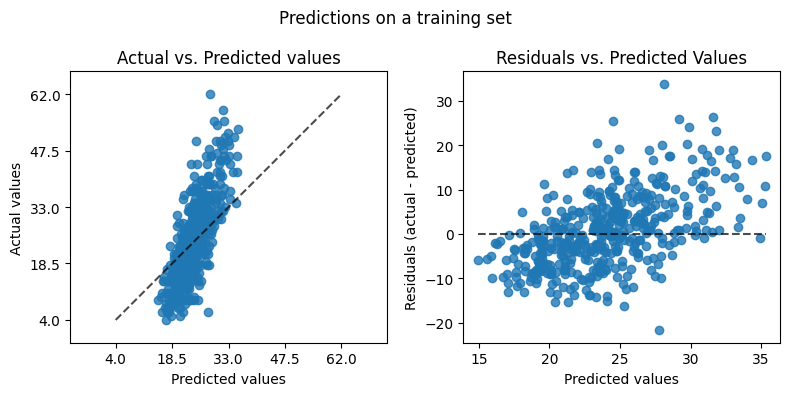

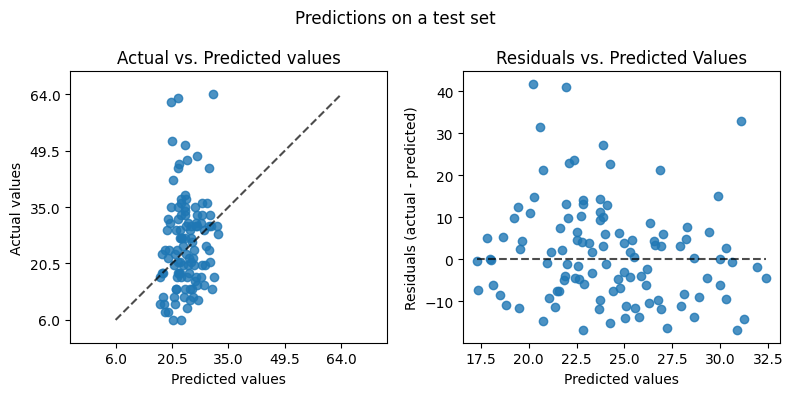

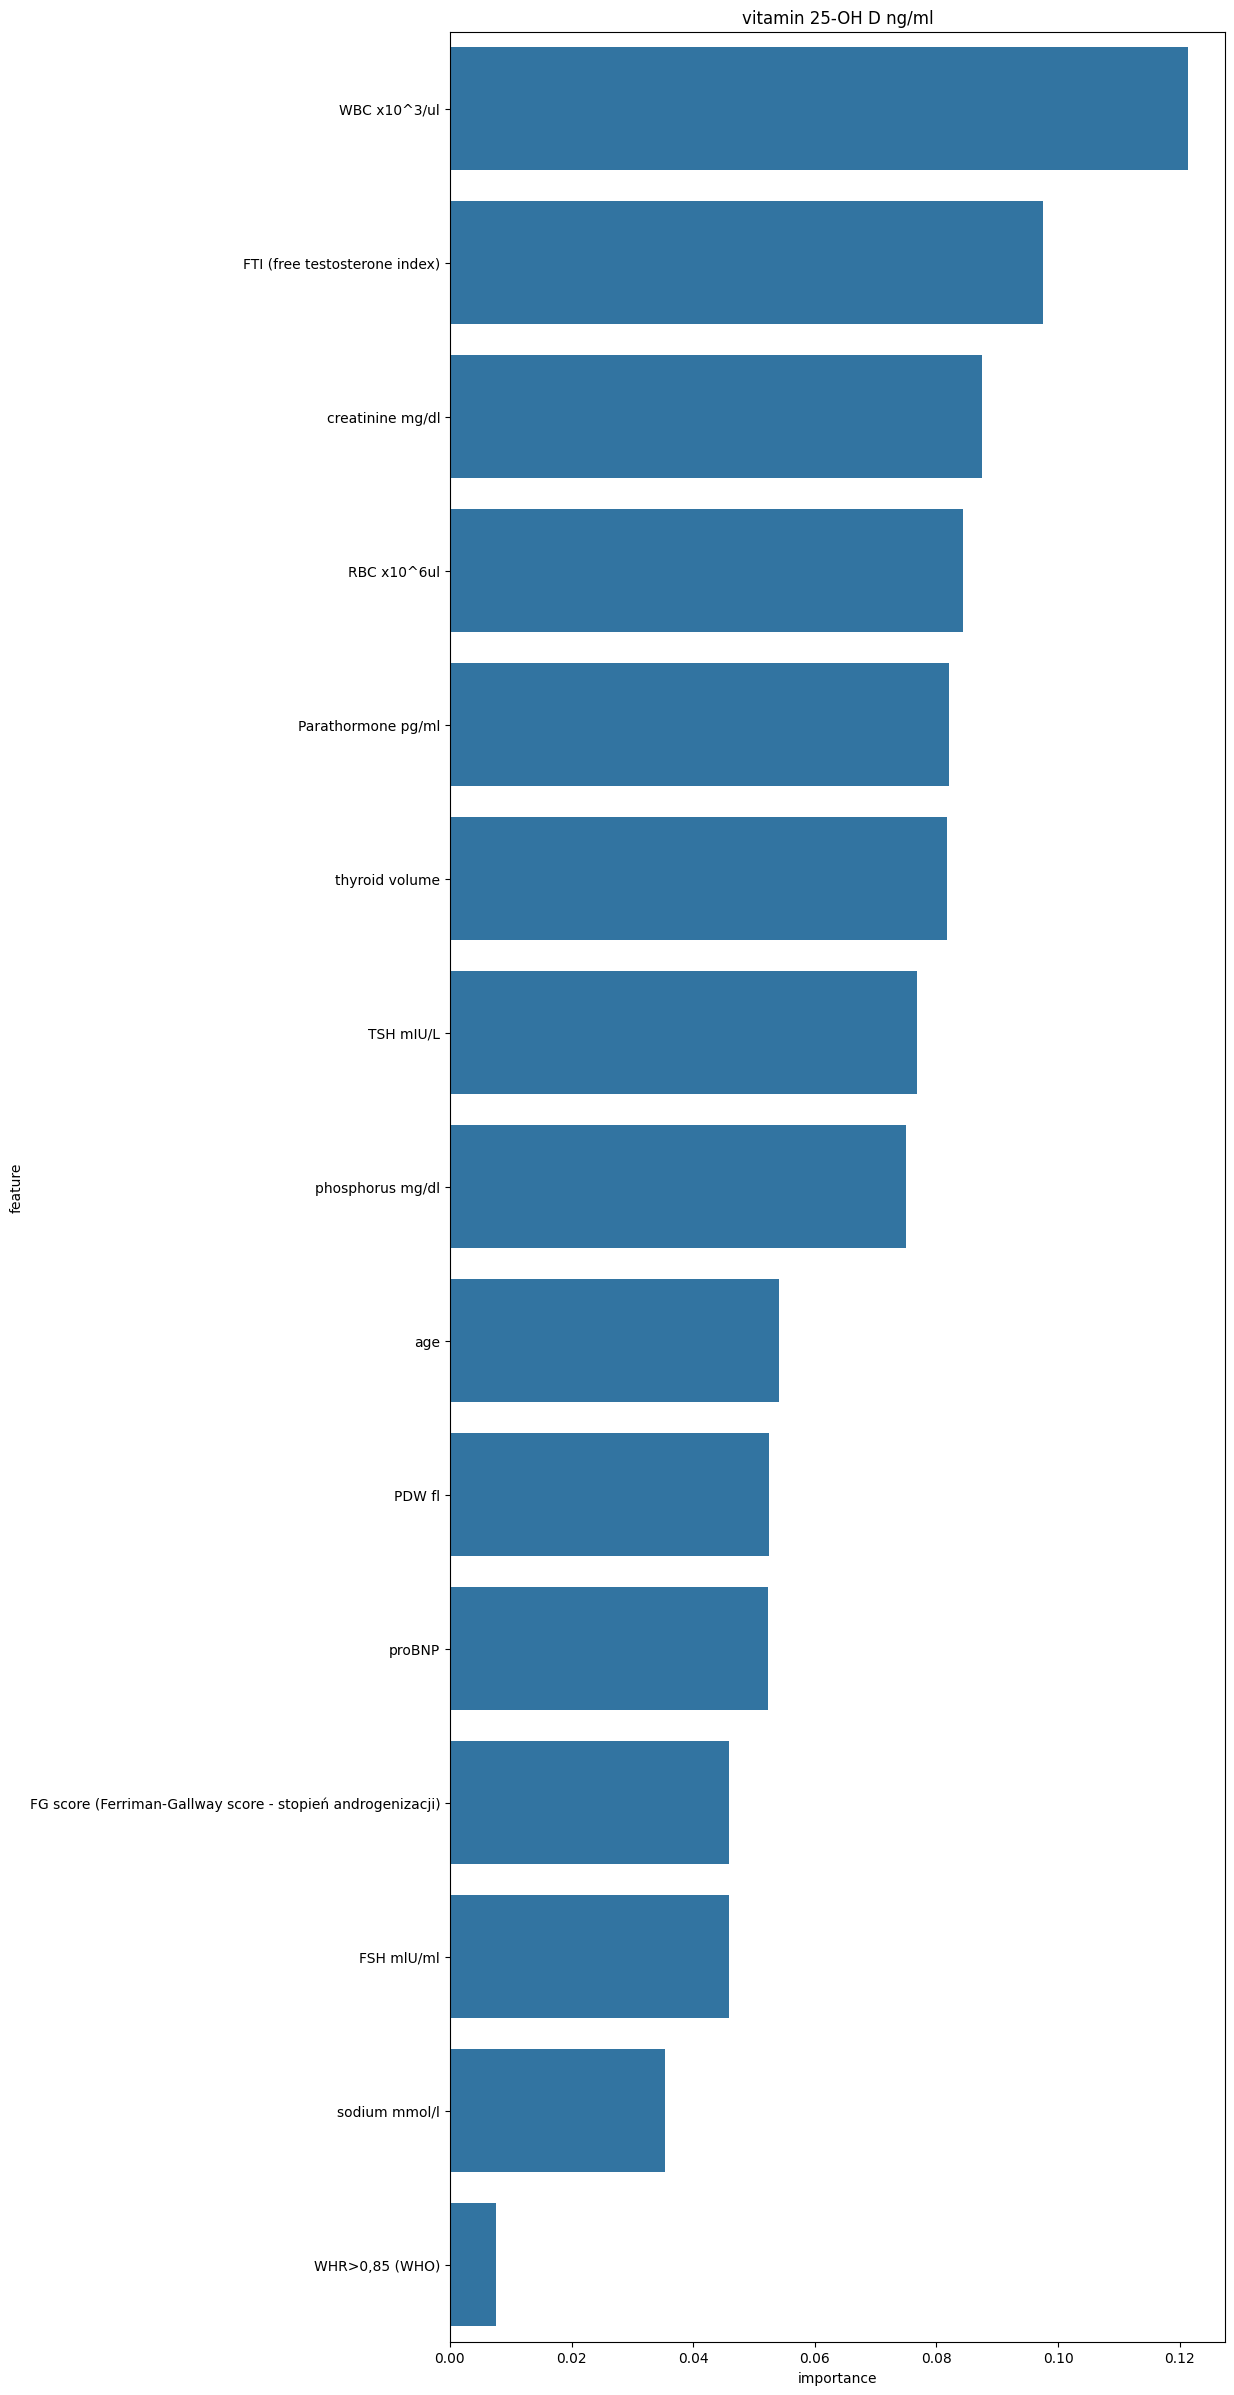

model  data_set      mse    mae    rmse     r2
0  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)  training   70.468  6.563   8.395  0.428
1  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)      test  144.483  9.101  12.020 -0.023

In [32]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, VITAMINE_D, X_train_vit_d[intersection_all_sets], y_train_vit_d, X_test_vit_d[intersection_all_sets], y_test_vit_d, tree_continuous_preprocessing, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df